In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

2024-10-19 12:20:31.643585: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 12:20:31.854150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 12:20:31.934692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 12:20:31.958213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 12:20:32.116822: I tensorflow/core/platform/cpu_feature_guar

In [20]:
rep_df = pd.read_csv("transactions/reputable_tnx_scored.csv")
ill_df = pd.read_csv("transactions/illicit_tnx_scored.csv")

rep_df['contract_status'] = 1
ill_df['contract_status'] = 0

In [21]:
df = pd.concat([rep_df, ill_df], ignore_index=True)
del rep_df, ill_df

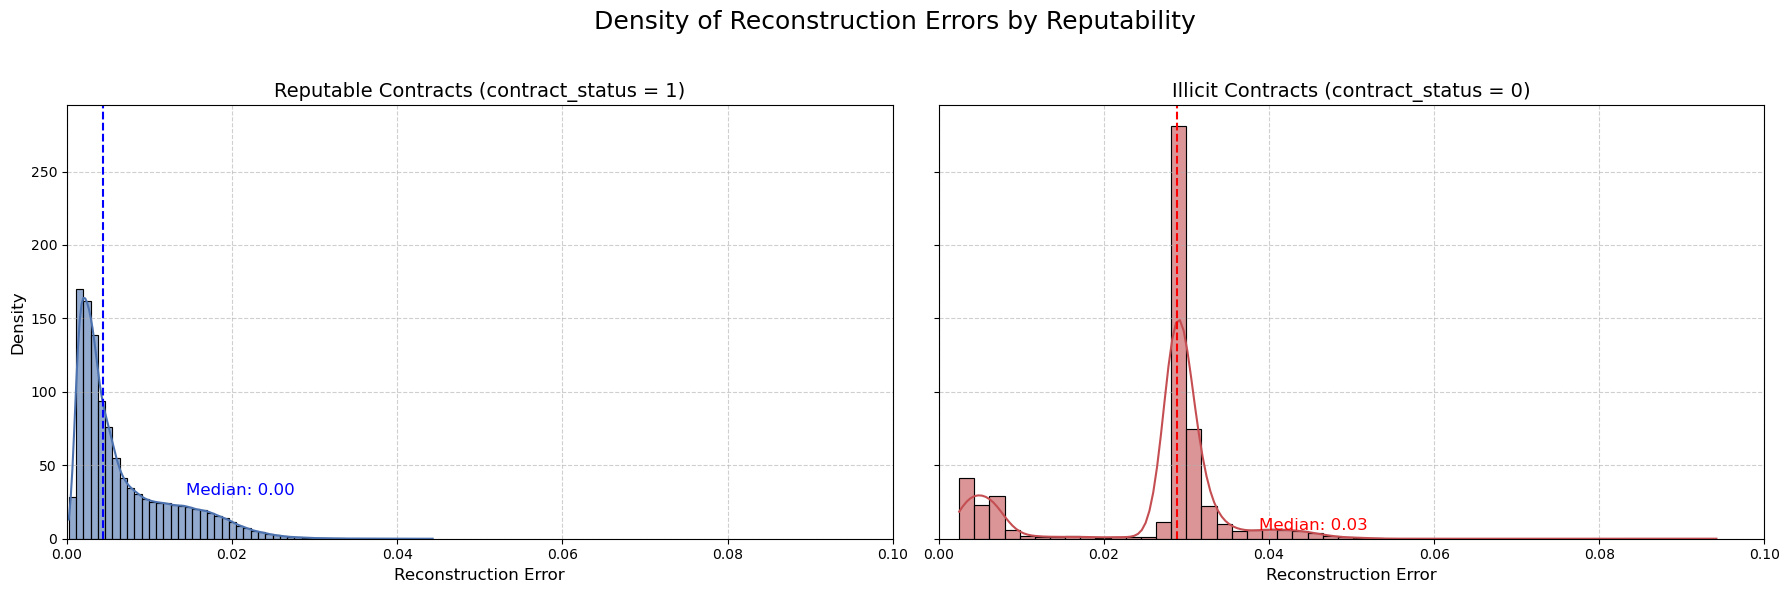

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate median values for annotations
median_reputable = df[df['contract_status'] == 1]['reconstruction_error'].median()
median_illicit = df[df['contract_status'] == 0]['reconstruction_error'].median()

# Create two subplots: one for contract_status=1 (reputable) and one for contract_status=0 (illicit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Common x-axis limit
x_limit = (0, 0.1)  # Adjust according to your data range

# Plot for contract_status = 1 (reputable) with density
sns.histplot(df[df['contract_status'] == 1]['reconstruction_error'], 
             bins=50, kde=True, color='#4C72B0', stat='density', ax=axes[0], alpha=0.6)
axes[0].set_title('Reputable Contracts (contract_status = 1)', fontsize=14)
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_xlim(x_limit)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[0].axvline(median_reputable, color='blue', linestyle='--')
axes[0].text(median_reputable + 0.01, 30, f'Median: {median_reputable:.2f}', color='blue', fontsize=12)

# Plot for contract_status = 0 (illicit) with density
sns.histplot(df[df['contract_status'] == 0]['reconstruction_error'], 
             bins=50, kde=True, color='#C44E52', stat='density', ax=axes[1], alpha=0.6)
axes[1].set_title('Illicit Contracts (contract_status = 0)', fontsize=14)
axes[1].set_xlabel('Reconstruction Error', fontsize=12)
axes[1].set_xlim(x_limit)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[1].axvline(median_illicit, color='red', linestyle='--')
axes[1].text(median_illicit + 0.01, 6, f'Median: {median_illicit:.2f}', color='red', fontsize=12)

# Set a common title and adjust layout
fig.suptitle('Density of Reconstruction Errors by Reputability', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale reconstruction error and apply sigmoid
df['scaled_rec_error'] = MinMaxScaler((0, 10)).fit_transform(df[['reconstruction_error']])
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

df['tnx_rep_score'] = 1 - sigmoid(df['scaled_rec_error'])

# Rescale tnx_rep_score to 0-1 range
df['rep_score'] = MinMaxScaler().fit_transform(df[['tnx_rep_score']])
df = df.drop(columns=['reconstruction_error', "tnx_rep_score", "scaled_rec_error"], axis=1)

In [23]:
df.columns

Index(['address', 'timeStamp', 'transaction_count_sent', 'total_value_sent',
       'avg_value_sent', 'min_value_sent', 'max_value_sent', 'gas_sum_sent',
       'gas_mean_sent', 'gasPrice_sum_sent', 'gasUsed_sum_sent',
       'gasUsed_mean_sent', 'error_count_sent',
       'unique_contracts_interacted_with_sent', 'avg_min_between_sent_tnx',
       'transaction_count_received', 'total_value_received',
       'avg_value_received', 'min_value_received', 'max_value_received',
       'gas_sum_received', 'gas_mean_received', 'gasPrice_sum_received',
       'gasUsed_sum_received', 'gasUsed_mean_received', 'error_count_received',
       'unique_contracts_interacted_with_received',
       'avg_min_between_received_tnx', 'time_diff_between_first_and_last',
       'avg_min_between_sent_tnx_missing',
       'avg_min_between_received_tnx_missing', 'contract_status', 'rep_score'],
      dtype='object')

In [7]:
from scipy import stats
import numpy as np
error_df = df
# Separate reconstruction errors by 'contract_status'
errors_reputable = error_df[error_df['contract_status'] == 1]['rep_score']
errors_illicit = error_df[error_df['contract_status'] == 0]['rep_score']

# 1. Check for normality using the Shapiro-Wilk test
shapiro_reputable = stats.shapiro(errors_reputable)
shapiro_illicit = stats.shapiro(errors_illicit)

print(f"Shapiro-Wilk Test for 'contract_status = 1' (reputable): p-value = {shapiro_reputable.pvalue}")
print(f"Shapiro-Wilk Test for 'contract_status = 0' (illicit): p-value = {shapiro_illicit.pvalue}")

# 2. Based on normality results, decide on which test to use
if shapiro_reputable.pvalue > 0.05 and shapiro_illicit.pvalue > 0.05:
    # Both groups are normally distributed, use a two-sample t-test
    t_stat, t_pvalue = stats.ttest_ind(errors_reputable, errors_illicit)
    print(f"Two-sample t-test: t-statistic = {t_stat}, p-value = {t_pvalue}")
else:
    # Not normally distributed, use Mann-Whitney U test
    u_stat, u_pvalue = stats.mannwhitneyu(errors_reputable, errors_illicit, alternative='less')
    print(f"Mann-Whitney U Test: U-statistic = {u_stat}, p-value = {u_pvalue}")


Shapiro-Wilk Test for 'contract_status = 1' (reputable): p-value = 2.775842072264759e-136
Shapiro-Wilk Test for 'contract_status = 0' (illicit): p-value = 4.4391536980825154e-98
Mann-Whitney U Test: U-statistic = 2536136833.0, p-value = 1.0


/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 237263.
  res = hypotest_fun_out(*samples, **kwds)
/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11727.
  res = hypotest_fun_out(*samples, **kwds)


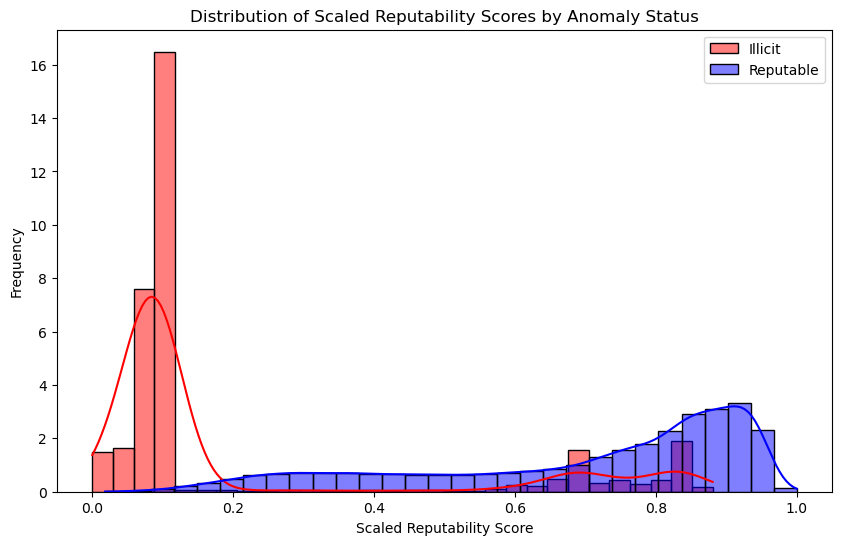

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histograms for scaled_rep_score for each class in is_reputable
plt.figure(figsize=(10, 6))

# # Histogram for reputable transactions (is_reputable = 1)
# sns.histplot(data=df[df['is_reputable'] == 1], x='scaled_rep_score', bins=30, kde=True, color='blue', label='Reputable')

# Histogram for non-reputable transactions (is_reputable = 0)
sns.histplot(data=df[df['contract_status'] == 0], x='rep_score', bins=30, kde=True, stat='density', color='red', label='Illicit')
sns.histplot(data=df[df['contract_status'] == 1], x='rep_score', bins=30, kde=True, color='blue', stat='density', label='Reputable')

# Plot formatting
plt.title('Distribution of Scaled Reputability Scores by Anomaly Status')
plt.xlabel('Scaled Reputability Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histograms for scaled_rep_score for each class in is_reputable
plt.figure(figsize=(10, 6))

# # Histogram for reputable transactions (is_reputable = 1)
# sns.histplot(data=df[df['is_reputable'] == 1], x='scaled_rep_score', bins=30, kde=True, color='blue', label='Reputable')

# Histogram for non-reputable transactions (is_reputable = 0)
sns.histplot(data=df[df['contract_status'] == 0], x='reconstruction_error', bins=30, kde=True, stat='density', color='red', label='Illicit')
sns.histplot(data=df[df['contract_status'] == 1], x='reconstruction_error', bins=30, kde=True, color='blue', stat='density', label='Reputable')

# Plot formatting
plt.title('Distribution of Reconstruction Error by Contract Status')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# LSTM for Transitions

## Test Stuff here

In [5]:
from tensorflow.keras.layers import Embedding, Concatenate, Input, LSTM, Dense, Flatten, GRU
from tensorflow.keras.models import Model

# Create an embedding for the contract address
unique_addresses = df['address'].unique()
address_to_idx = {address: idx for idx, address in enumerate(unique_addresses)}
df['address_idx'] = df['address'].map(address_to_idx)

# Prepare data with contract embeddings
def prepare_sequences_with_embeddings(df, window_size=50):
    sequences = []
    targets = []
    contract_ids = []
    
    for address in df['address'].unique():
        contract_df = df[df['address'] == address]
        rep_scores = contract_df['rep_score'].values
        address_idx = contract_df['address_idx'].values[0]
        
        # Create sequences
        for i in range(len(rep_scores) - window_size):
            sequences.append(rep_scores[i:i + window_size])
            targets.append(rep_scores[i + window_size])
            contract_ids.append(address_idx)

    return np.array(sequences), np.array(targets), np.array(contract_ids)

X, y, contract_ids = prepare_sequences_with_embeddings(df, window_size=50)

In [6]:

# Reshape X for LSTM and add contract embeddings
X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 feature (rep_score)

# Step 1: Define inputs
rep_score_input = Input(shape=(X.shape[1], X.shape[2]), name='rep_score_input')
contract_input = Input(shape=(1,), name='contract_input')

# Step 2: Contract embedding layer
contract_embedding = Embedding(input_dim=len(unique_addresses), output_dim=10)(contract_input)
contract_embedding = Flatten()(contract_embedding)  # Flatten embedding output

# Step 3: LSTM model
lstm_output = GRU(50, activation='relu')(rep_score_input)

# Step 4: Concatenate LSTM output and contract embedding
concatenated = Concatenate()([lstm_output, contract_embedding])

# Step 5: Output layer
output = Dense(1)(concatenated)

# Step 6: Build and compile the model
model = Model(inputs=[rep_score_input, contract_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
X_train, X_test, y_train, y_test, contract_ids_train, contract_ids_test = train_test_split(
    X, y, contract_ids, test_size=0.2, random_state=42)
# history = model.fit([X_train, contract_ids_train], y_train, epochs=5, batch_size=32, validation_data=([X_test, contract_ids_test], y_test))


I0000 00:00:1727633255.529560  239612 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727633255.558184  239612 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727633255.558244  239612 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727633255.559748  239612 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727633255.559804  239612 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [7]:
import tensorflow as tf
model = tf.keras.models.load_model("gru_contract_rep_score_model.keras")

/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Make predictions on the test set
y_pred = model.predict([X_test, contract_ids_test])

# Step 2: Calculate mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

I0000 00:00:1727633257.237993  239956 service.cc:146] XLA service 0x7f0fb8018af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727633257.238076  239956 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-09-29 20:07:37.267995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 20:07:37.347587: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  20/4985 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step 

I0000 00:00:1727633257.574660  239956 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4985/4985 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
Mean Squared Error: 0.04258663303627613
Mean Absolute Error: 0.17177618106279213


In [9]:
# Step 1: Calculate lead time for each test sample
lead_times = []

for i in range(len(y_test)):
    if y_test[i] < 0.5:  # If the actual contract becomes non-reputable
        predicted_idx = np.where(y_pred[:i] < 0.5)[0]  # When did the model predict non-reputability?
        if len(predicted_idx) > 0:
            lead_time = i - predicted_idx[0]  # How many steps earlier was it predicted?
            lead_times.append(lead_time)

# Step 2: Calculate average lead time
if len(lead_times) > 0:
    avg_lead_time = np.mean(lead_times)
    print(f"Average Lead Time: {avg_lead_time} timesteps")
else:
    print("No transitions were predicted early.")


Average Lead Time: 79947.40957182183 timesteps


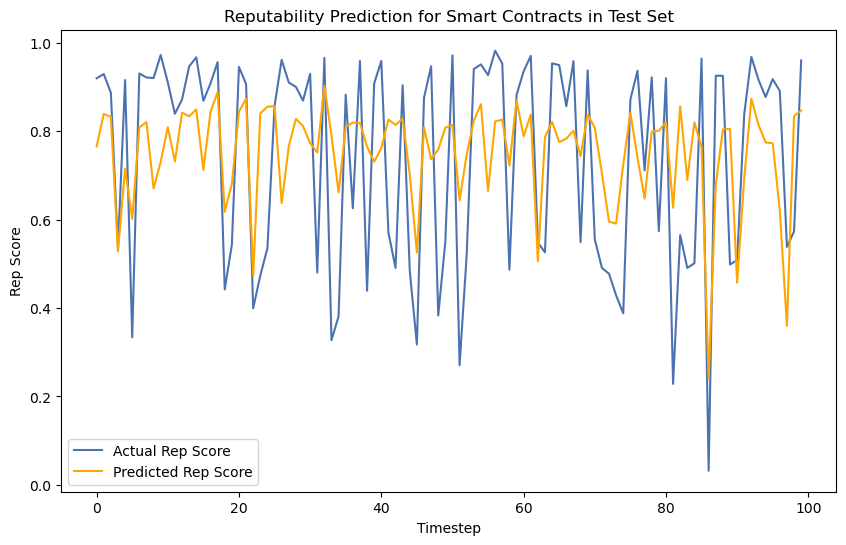

In [69]:
import matplotlib.pyplot as plt

# Step 1: Select a range of predictions to plot
start_idx = 0  # Index where you start plotting the test set
end_idx = 100  # Number of timesteps you want to visualize

# Step 2: Plot the actual and predicted rep_score for this range
plt.figure(figsize=(10, 6))

# Plot actual rep_score values
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label="Actual Rep Score", color='#4C72B0')

# Plot predicted rep_score values
plt.plot(range(start_idx, end_idx), y_pred[start_idx:end_idx], label="Predicted Rep Score", color='orange')

# Set title and labels
plt.title(f"Reputability Prediction for Smart Contracts in Test Set")
plt.xlabel("Timestep")
plt.ylabel("Rep Score")
plt.legend()
plt.show()


In [44]:
# Specify the contract address you want to check
contract_address = '0x06f3c323f0238c72bf35011071f2b5b7f43a054c'  # Replace with the actual address

# Filter the dataframe to get only the data for the specific contract
contract_df = df[df['address'] == contract_address]
X_contract, y_contract, contract_ids_contract = prepare_sequences_with_embeddings(contract_df, window_size=50)

X_contract = X_contract.reshape((X_contract.shape[0], X_contract.shape[1], 1))  # 1 feature (rep_score)
y_contract_pred = model.predict([X_contract, contract_ids_contract])

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


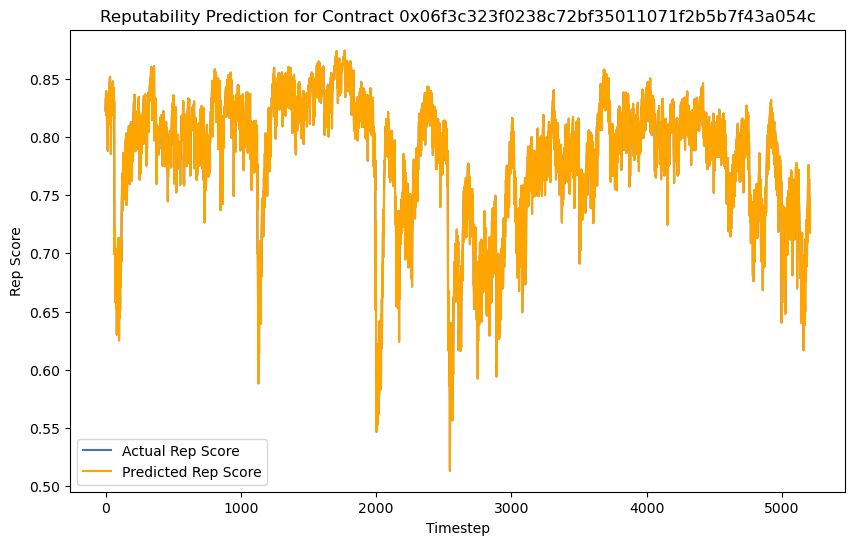

In [37]:
import matplotlib.pyplot as plt

# Plot actual vs predicted rep_score for the specific contract
plt.figure(figsize=(10, 6))

# Plot actual rep_score
plt.plot(range(len(y_contract)), y_contract_pred, label="Actual Rep Score", color='#4C72B0')

# Plot predicted rep_score
plt.plot(range(len(y_contract)), y_contract_pred, label="Predicted Rep Score", color='orange')

# Set title and labels
plt.title(f"Reputability Prediction for Contract 0x06f3c323f0238c72bf35011071f2b5b7f43a054c")
plt.xlabel("Timestep")
plt.ylabel("Rep Score")
plt.legend()
plt.show()


In [58]:
contract_df['timeStamp']

22884    2020-11-03 04:00:00
22885    2020-11-03 06:00:00
22886    2020-11-03 07:00:00
22887    2020-11-03 11:00:00
22888    2020-11-03 12:00:00
                ...         
28138    2023-12-07 13:00:00
28139    2023-12-07 14:00:00
28140    2023-12-07 15:00:00
28141    2023-12-07 19:00:00
28142    2023-12-07 20:00:00
Name: timeStamp, Length: 5259, dtype: object

In [52]:
y_contract.shape

(5209,)

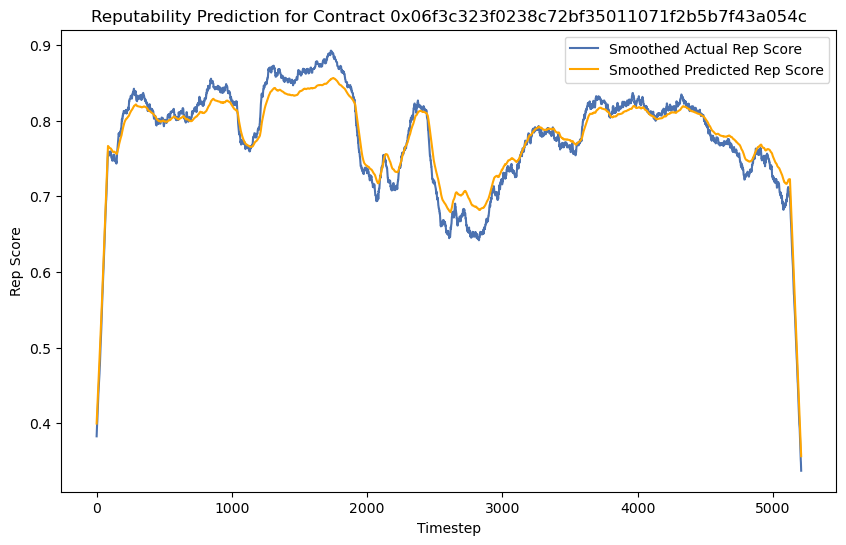

In [67]:
# If y_contract_pred is multidimensional, flatten it
if len(np.array(y_contract_pred).shape) > 1:
    y_contract_pred = np.array(y_contract_pred).flatten()

if len(np.array(y_contract).shape) > 1:
    y_contract = np.array(y_contract).flatten()

# Simple moving average function
def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Set window size for smoothing
window_size = 168

# Smooth the actual and predicted rep_score
smoothed_actual = simple_moving_average(y_contract, window_size)
smoothed_pred = simple_moving_average(y_contract_pred, window_size)

# Plot smoothed actual vs predicted rep_score for the specific contract
plt.figure(figsize=(10, 6))

# Plot smoothed actual rep_score
plt.plot(range(len(smoothed_actual)), smoothed_actual, label="Smoothed Actual Rep Score", color='#4C72B0')

# Plot smoothed predicted rep_score
plt.plot(range(len(smoothed_pred)), smoothed_pred, label="Smoothed Predicted Rep Score", color='orange')

# Set title and labels
plt.title(f"Reputability Prediction for Contract 0x06f3c323f0238c72bf35011071f2b5b7f43a054c")
plt.xlabel("Timestep")
plt.ylabel("Rep Score")
plt.legend()
plt.show()


In [64]:
# Prepare the sequences for this specific contract
def prepare_sequence_for_contract(contract_df, window_size=50):
    sequences = []
    contract_id = contract_df['address_idx'].values[0]  # Get contract embedding index
    rep_scores = contract_df['rep_score'].values

    # Create sequences using a sliding window
    for i in range(len(rep_scores) - window_size):
        sequences.append(rep_scores[i:i + window_size])

    return np.array(sequences), contract_id

# Prepare the input sequence for the specific contract
X_contract, contract_id = prepare_sequence_for_contract(contract_df, window_size=50)

# Reshape the input data for the GRU model
X_contract = X_contract.reshape((X_contract.shape[0], X_contract.shape[1], 1))  # 1 feature (rep_score)


## LSTM V2

In [ ]:
import cudf
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Convert pandas DataFrame to cuDF DataFrame for GPU processing
gdf = cudf.DataFrame.from_pandas(df)

# Features to be used for the LSTM
features = df.drop(columns=['address', 'timeStamp', 'rep_score']).columns

# Target variable
target = 'rep_score'

# Scaling using MinMaxScaler (on CPU for now, but later operations will be on GPU)
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert the scaled data back to cuDF for GPU-based processing
gdf[features] = cudf.DataFrame.from_pandas(df[features])

# Vectorized sequence creation function
def create_sequences_vectorized(gdf, features, target, time_steps=24):
    X = gdf[features].values.reshape(-1, time_steps, len(features))
    y = gdf[target].values[time_steps:]
    return X, y

# Create sequences with 24-hour time steps
time_steps = 24
X, y = create_sequences_vectorized(gdf, features, target, time_steps)

# Convert cupy arrays back to numpy for train-test split and subsequent model training
X = cp.asnumpy(X)
y = cp.asnumpy(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of the training and test sets
print(f'Training set shape: {X_train.shape}, Test set shape: {X_test.shape}')

In [1]:
import cudf
import dask
import dask.dataframe as dd
import numpy as np
import gc
import os
import csv
import matplotlib.pyplot as plt
from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Concatenate, Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

# Load the DataFrame using cuDF (GPU-accelerated)
df = cudf.read_csv('tnx_scored.csv')

# Features to scale (dropping columns not needed for scaling)
features = df.drop(columns=['address', 'timeStamp', 'rep_score', 'contract_status']).columns

# Scaling using GPU-accelerated MinMaxScaler
scaler = cuMinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert contract address to an index and store it
unique_addresses = df['address'].unique().to_pandas() 
address_to_idx = {address: idx for idx, address in enumerate(unique_addresses)}
df['address_idx'] = df['address'].map(address_to_idx)

# Save train/val/test splits for consistency
train_file = 'train_df.csv'
val_file = 'val_df.csv'
test_file = 'test_df.csv'

if os.path.exists(train_file) and os.path.exists(val_file) and os.path.exists(test_file):
    # Load saved train, val, test splits
    train_df = cudf.read_csv(train_file)
    val_df = cudf.read_csv(val_file)
    test_df = cudf.read_csv(test_file)
else:
    # Split at the contract (address) level, preserving all sequences for each address
    addresses = df['address'].unique().to_pandas()

    # Split contracts into train, validation, and test (70%, 15%, 15%)
    train_addresses, test_addresses = train_test_split(addresses, test_size=0.15, shuffle=True, random_state=42)
    train_addresses, val_addresses = train_test_split(train_addresses, test_size=0.15, shuffle=True, random_state=42)

    # Create train, validation, and test sets based on contract addresses
    train_df = df[df['address'].isin(train_addresses)]
    val_df = df[df['address'].isin(val_addresses)]
    test_df = df[df['address'].isin(test_addresses)]

    # Save the splits to CSV for consistency
    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)


# Function to prepare sequences and embeddings
def prepare_sequences_with_embeddings(df, window_size):
    sequences = []
    targets = []
    contract_ids = []
    
    for address in df['address'].unique().to_pandas():
        contract_df = df[df['address'] == address].to_pandas()
        rep_scores = contract_df['rep_score'].values
        address_idx = contract_df['address_idx'].values[0]
        
        # Create sequences
        for i in range(len(rep_scores) - window_size):
            sequences.append(rep_scores[i:i + window_size])
            targets.append(rep_scores[i + window_size])
            contract_ids.append(address_idx)

    return np.array(sequences), np.array(targets), np.array(contract_ids)

2024-10-27 18:36:00.976807: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 18:36:01.198995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 18:36:01.289923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 18:36:01.311444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 18:36:01.469753: I tensorflow/core/platform/cpu_feature_guar

In [21]:
import pandas as pd 
df = pd.read_csv("tnx_scored.csv")
df = df[df['contract_status'] == 1]

In [22]:
df['rep_score'].mean()

0.6960805118566316

In [23]:
df['address'].value_counts()

address
0x06f3c323f0238c72bf35011071f2b5b7f43a054c    5259
0xa49d7499271ae71cd8ab9ac515e6694c755d400c    4213
0xc6dddb5bc6e61e0841c54f3e723ae1f3a807260b    3990
0x43ab765ee05075d78ad8aa79dcb1978ca3079258    3792
0xc28e931814725bbeb9e670676fabbcb694fe7df2    3754
                                              ... 
0x9348e94a447bf8b2ec11f374d3f055fd47d936df       2
0xd3c325848d7c6e29b574cb0789998b2ff901f17e       2
0x80fb784b7ed66730e8b1dbd9820afd29931aab03       2
0x5224f552f110ec78e6e0468138950ae5f3040942       1
0x3449fc1cd036255ba1eb19d65ff4ba2b8903a69a       1
Name: count, Length: 291, dtype: int64

Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 32, Learning Rate 0.001
Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 32, Learning Rate 0.0005
Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 32, Learning Rate 0.0001
Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 64, Learning Rate 0.001
Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 64, Learning Rate 0.0005
Skipping already completed combination: Window Size 25, LSTM Units 32, Batch Size 64, Learning Rate 0.0001
Skipping already completed combination: Window Size 25, LSTM Units 64, Batch Size 32, Learning Rate 0.001
Skipping already completed combination: Window Size 25, LSTM Units 64, Batch Size 32, Learning Rate 0.0005
Skipping already completed combination: Window Size 25, LSTM Units 64, Batch Size 32, Learning Rate 0.0001
Skipping already completed combination: 

I0000 00:00:1728903917.496692  515490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728903917.497556  515490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728903917.497625  515490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728903917.500270  515490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728903917.500452  515490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1728903919.109243  523915 service.cc:146] XLA service 0x7fc10c003350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728903919.109284  523915 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-10-14 13:05:19.136805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-14 13:05:19.320111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-14 13:05:20.282333: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 444 bytes spill stores, 444 bytes spill loads



   6/1794 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0410 

I0000 00:00:1728903921.074138  523915 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1790/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0421

2024-10-14 13:05:50.243210: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 444 bytes spill stores, 444 bytes spill loads



1794/1794 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0421 - val_loss: 0.0465 - learning_rate: 5.0000e-04
Epoch 2/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0418 - val_loss: 0.0461 - learning_rate: 5.0000e-04
Epoch 3/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0423 - val_loss: 0.0464 - learning_rate: 5.0000e-04
Epoch 4/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0422
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0422 - val_loss: 0.0462 - learning_rate: 5.0000e-04
Epoch 5/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0420 - val_loss: 0.0464 - learning_rate: 2.5000e-04
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Loading model from model_checkpoint_50_128_64_0.0005.keras
Epoch 1/50
1791/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417

2024-10-14 13:08:29.378569: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 440 bytes spill stores, 440 bytes spill loads



1794/1794 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0417 - val_loss: 0.0464 - learning_rate: 5.0000e-04
Epoch 2/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0416 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 3/50
1793/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0415
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - loss: 0.0415 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 4/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0413 - val_loss: 0.0462 - learning_rate: 2.5000e-04
Epoch 5/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0412 - val_loss: 0.0463 - learning_rate: 2.5000e-04
Epoch 6/50
1792/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0417
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0417 - val_loss: 0.0461 - learning_rate: 2.5000e-04
Epoch 7/50
1794/1794 ━━━━━━━━━━━━

/tmp/ipykernel_515490/631616986.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


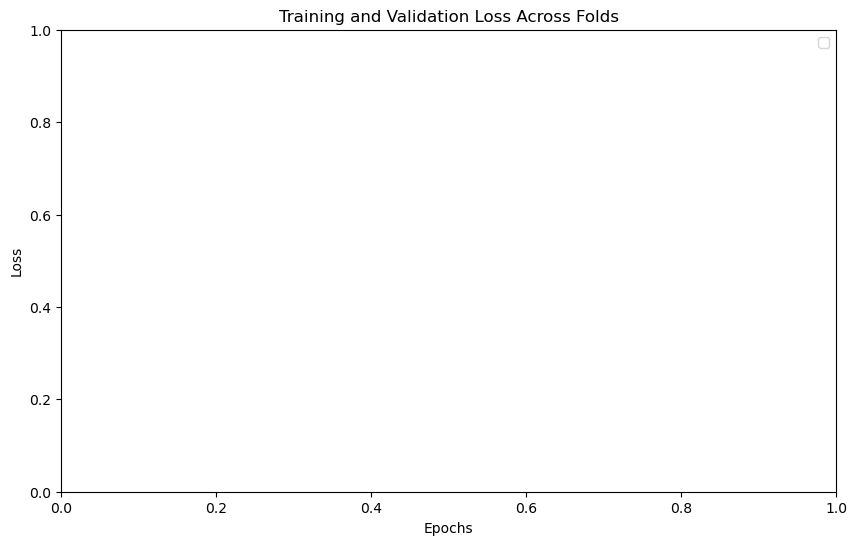

In [3]:

# Function to prepare sequences and embeddings
def prepare_sequences_with_embeddings(df, window_size):
    sequences = []
    targets = []
    contract_ids = []
    
    for address in df['address'].unique().to_pandas():
        contract_df = df[df['address'] == address].to_pandas()
        rep_scores = contract_df['rep_score'].values
        address_idx = contract_df['address_idx'].values[0]
        
        # Create sequences
        for i in range(len(rep_scores) - window_size):
            sequences.append(rep_scores[i:i + window_size])
            targets.append(rep_scores[i + window_size])
            contract_ids.append(address_idx)

    return np.array(sequences), np.array(targets), np.array(contract_ids)

# Ensure GPU utilization
K.set_floatx('float32')

# Hyperparameters
window_sizes = [25, 50]
lstm_units = [32, 64, 128]
batch_sizes = [32, 64]
learning_rates = [0.001, 0.0005, 0.0001]

# CSV file to save results
csv_file = 'model_results.csv'
csv_file_v2 = 'model_results_avg.csv'
csv_columns = ['Fold', 'Window Size', 'LSTM Units', 'Batch Size', 'Learning Rate', 'MSE', 'MAE', 'Best Val Loss', 'Best Epoch']

# Load already completed hyperparameters from CSV
completed_combinations = set()
# if os.path.exists(csv_file):
#     with open(csv_file, 'r') as file:
#         reader = csv.DictReader(file)
#         for row in reader:
#             completed_combinations.add((int(row['Window Size']), int(row['LSTM Units']),
#                                         int(row['Batch Size']), float(row['Learning Rate'])))

if os.path.exists(csv_file_v2):
    with open(csv_file_v2, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            completed_combinations.add((int(row['Window Size']), int(row['LSTM Units']),
                                        int(row['Batch Size']), float(row['Learning Rate'])))

# Function to build or load model from checkpoint
def build_or_load_model(window_size, lstm_units, learning_rate, input_dim, num_contracts, model_path=None):
    if model_path and os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        return load_model(model_path)
    else:
        rep_score_input = Input(shape=(window_size, input_dim), name='rep_score_input')
        contract_input = Input(shape=(1,), name='contract_input')

        # Contract embedding layer
        contract_embedding = Embedding(input_dim=num_contracts, output_dim=10)(contract_input)
        contract_embedding = Flatten()(contract_embedding)  # Flatten embedding output

        # LSTM layer
        lstm_output = LSTM(lstm_units, activation='relu')(rep_score_input)

        # Concatenate LSTM output and contract embedding
        concatenated = Concatenate()([lstm_output, contract_embedding])

        # Output layer
        output = Dense(1)(concatenated)

        # Build and compile the model
        model = Model(inputs=[rep_score_input, contract_input], outputs=output)
        model.compile(optimizer='adam', loss='mse')
        return model

# Function to save results to CSV
def save_results_to_csv(data, csv_file, csv_columns):
    file_exists = os.path.isfile(csv_file)
    with open(csv_file, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=csv_columns)
        if not file_exists:
            writer.writeheader()  # Write header only once
        writer.writerow(data)

# K-Fold Cross Validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

# Track overall training and validation losses for plotting
history_list = []

for window_size in window_sizes:
    for lstm_unit in lstm_units:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Check if this combination has already been completed
                if (window_size, lstm_unit, batch_size, learning_rate) in completed_combinations:
                    print(f"Skipping already completed combination: Window Size {window_size}, LSTM Units {lstm_unit}, Batch Size {batch_size}, Learning Rate {learning_rate}")
                    continue

                # Prepare data for current window size
                X_train, y_train, contract_ids_train = prepare_sequences_with_embeddings(train_df, window_size)
                X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 1 feature (rep_score)

                fold_mse = []
                fold_mae = []
                fold_val_loss = []  # To store validation loss for each fold
                all_train_loss = []
                all_val_loss = []

                # Path to save the model for this combination
                model_checkpoint_path = f"model_checkpoint_{window_size}_{lstm_unit}_{batch_size}_{learning_rate}.keras"

                # K-Fold Cross Validation
                fold_num = 1  # Initialize fold number
                for train_index, val_index in kf.split(X_train):
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                    contract_ids_train_fold, contract_ids_val_fold = contract_ids_train[train_index], contract_ids_train[val_index]

                    # Build or load the model
                    model = build_or_load_model(window_size, lstm_unit, learning_rate, 1, len(unique_addresses), model_checkpoint_path)

                    # Define callbacks
                    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                    checkpoint = ModelCheckpoint(model_checkpoint_path, save_best_only=True, save_freq='epoch', monitor='val_loss')
                    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

                    # Train the model
                    history = model.fit([X_train_fold, contract_ids_train_fold], y_train_fold, 
                                        epochs=50, 
                                        batch_size=batch_size, 
                                        validation_data=([X_val_fold, contract_ids_val_fold], y_val_fold), 
                                        callbacks=[early_stopping, checkpoint, reduce_lr])

                    # Append losses for plotting later
                    all_train_loss.extend(history.history['loss'])
                    all_val_loss.extend(history.history['val_loss'])

                    # Predict on the validation set
                    y_pred = model.predict([X_val_fold, contract_ids_val_fold])

                    # Calculate MSE and MAE for this fold
                    mse = mean_squared_error(y_val_fold, y_pred)
                    mae = mean_absolute_error(y_val_fold, y_pred)

                    # Append validation loss and metrics for each fold
                    fold_mse.append(mse)
                    fold_mae.append(mae)
                    fold_val_loss.append(np.min(history.history['val_loss']))  # Append minimum val_loss for this fold

                    # Save results for the current fold to CSV
                    save_results_to_csv({
                        'Fold': fold_num,  # Add fold number
                        'Window Size': window_size,
                        'LSTM Units': lstm_unit,
                        'Batch Size': batch_size,
                        'Learning Rate': learning_rate,
                        'MSE': mse,  # Save per fold MSE
                        'MAE': mae,  # Save per fold MAE
                        'Best Val Loss': np.min(history.history['val_loss']),  # Save best val_loss for the fold
                        'Best Epoch': np.argmin(history.history['val_loss']) + 1  # Save best epoch for the fold
                    }, csv_file, csv_columns)

                    # Increment fold number
                    fold_num += 1

                    # Clear memory after each fold to avoid kernel crashes
                    del model
                    gc.collect()

                # Calculate the average MSE, MAE, and Val Loss across all folds
                avg_mse = np.mean(fold_mse)
                avg_mae = np.mean(fold_mae)
                avg_val_loss = np.mean(fold_val_loss)  # Average validation loss over all folds
                best_epoch = np.argmin(all_val_loss) + 1  # Epochs start from 1

                # Optionally, save the average metrics across all folds after all K-Folds are completed
                save_results_to_csv({
                    'Fold': 'Average',  # Label as "Average" instead of a fold number
                    'Window Size': window_size,
                    'LSTM Units': lstm_unit,
                    'Batch Size': batch_size,
                    'Learning Rate': learning_rate,
                    'MSE': avg_mse,  # Save avg MSE
                    'MAE': avg_mae,  # Save avg MAE
                    'Best Val Loss': avg_val_loss,  # Saving avg validation loss across folds
                    'Best Epoch': best_epoch
                }, csv_file_v2, csv_columns)


# Plot the training and validation loss across folds
plt.figure(figsize=(10, 6))
for i, (train_loss, val_loss) in enumerate(history_list):
    plt.plot(train_loss, label=f'Fold {i+1} Training Loss')
    plt.plot(val_loss, label=f'Fold {i+1} Validation Loss')

plt.title('Training and Validation Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Best Hyperparameters:
Window Size: 50, LSTM Units: 128, Batch Size: 64, Learning Rate: 0.0001
Loaded model from model_checkpoint_50_128_64_0.0001.keras
Epoch 1/50
2690/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0424

2024-10-14 16:12:02.831726: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 440 bytes spill stores, 440 bytes spill loads



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0424 - val_loss: 0.0477
Epoch 2/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.0433 - val_loss: 0.0495
Epoch 3/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0431 - val_loss: 0.0482
Epoch 4/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0426 - val_loss: 0.0477
Epoch 5/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.0427 - val_loss: 0.0479
Epoch 6/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.0427 - val_loss: 0.0480
Epoch 7/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0425 - val_loss: 0.0477
Epoch 8/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0427 - val_loss: 0.0487
Epoch 9/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.0426 - val_loss: 0.0479
Epoch 10/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0427 - val_loss: 0.0479
Epoch 11/50
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.0424 - val_loss: 0.0477
Epoch 12/50
2691/26

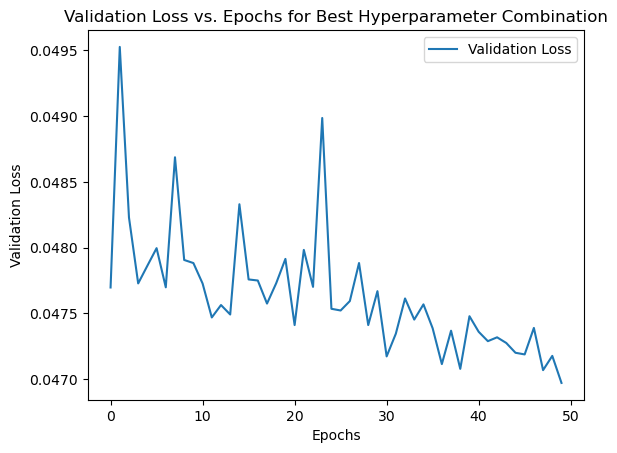

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the CSV file that contains the hyperparameter tuning results
csv_file = 'model_results_avg.csv'
df = pd.read_csv(csv_file)

# Find the row with the minimum validation loss
best_model_row = df.loc[df['Best Val Loss'].idxmin()]

# Extract the best hyperparameters
best_window_size = best_model_row['Window Size']
best_lstm_units = best_model_row['LSTM Units']
best_batch_size = best_model_row['Batch Size']
best_learning_rate = best_model_row['Learning Rate']

print(f"Best Hyperparameters:\n"
      f"Window Size: {best_window_size}, "
      f"LSTM Units: {best_lstm_units}, "
      f"Batch Size: {best_batch_size}, "
      f"Learning Rate: {best_learning_rate}")

# Path to the best model's checkpoint
best_model_checkpoint_path = f"model_checkpoint_{best_window_size}_{best_lstm_units}_{best_batch_size}_{best_learning_rate}.keras"

# Load the best model
if os.path.exists(best_model_checkpoint_path):
    model = load_model(best_model_checkpoint_path)
    print(f"Loaded model from {best_model_checkpoint_path}")

    # Assuming you already have the data prepared
    X_train, y_train, contract_ids_train = prepare_sequences_with_embeddings(train_df, best_window_size)
    X_val, y_val, contract_ids_val = prepare_sequences_with_embeddings(val_df, best_window_size)

    # Reshape the inputs if necessary
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Re-train the model with the same parameters to capture the history
    history = model.fit([X_train, contract_ids_train], y_train,
                        epochs=50,  # Use the appropriate number of epochs
                        batch_size=best_batch_size,
                        validation_data=([X_val, contract_ids_val], y_val),
                        verbose=1)

    # Plot the validation loss over epochs
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Epochs for Best Hyperparameter Combination')
    plt.legend()
    plt.show()

else:
    print(f"Checkpoint file {best_model_checkpoint_path} not found.")


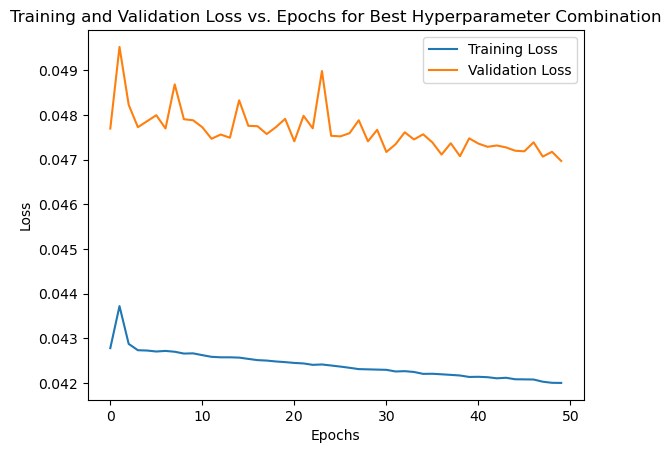

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs for Best Hyperparameter Combination')
plt.legend()
plt.show()

In [48]:
import numpy as np
import pandas as pd
# Get unique contract addresses
df = test_df.to_pandas()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['rep_score'])

contracts = df['address'].unique()

# Initialize list to store trend data
trend_data = []

# Loop through each contract and calculate the trend (slope)
for contract in contracts:
    contract_data = df[df['address'] == contract]

    # Ensure there are at least 2 data points to calculate a slope
    if len(contract_data) < 25:
        print(f"Skipping contract {contract} due to insufficient data points")
        continue

    # Set up time and reputability score values
    x = np.arange(len(contract_data))  # Use indices as a proxy for time
    y = contract_data['rep_score'].values
    
    try:
        # Attempt to calculate slope using np.polyfit
        slope = np.polyfit(x, y, 1)[0]
    except np.linalg.LinAlgError:
        # Fallback to linregress if np.polyfit fails
        print(f"SVD did not converge for contract {contract}, using linregress instead")
        slope, intercept, _, _, _ = linregress(x, y)
    
    # Append the contract and its slope to trend_data
    trend_data.append((contract, slope))

# Create a DataFrame to store the trend data
trend_df = pd.DataFrame(trend_data, columns=['address', 'slope'])

# Select representative contracts based on trend categories
# Top 2 increasing, bottom 2 decreasing, 2 stable, and 2 with high variance

# 1. Increasing contracts (Top 2 by slope)
increasing_contracts = trend_df.nlargest(2, 'slope')['address'].tolist()

# 2. Decreasing contracts (Bottom 2 by slope)
decreasing_contracts = trend_df.nsmallest(2, 'slope')['address'].tolist()

# 3. Stable contracts (slope close to zero)
stable_contracts = trend_df[(trend_df['slope'] > -0.01) & (trend_df['slope'] < 0.01)].sample(2)['address'].tolist()

# 4. High variance contracts (representing sudden shifts)
variance_data = df.groupby('address')['rep_score'].var().reset_index()
variance_contracts = variance_data.nlargest(2, 'rep_score')['address'].tolist()

# Combine selected contracts
selected_contracts = increasing_contracts + decreasing_contracts + stable_contracts + variance_contracts

# Display selected contracts for qualitative analysis
print("Selected contracts for qualitative analysis:")
print("Increasing contracts:", increasing_contracts)
print("Decreasing contracts:", decreasing_contracts)
print("Stable contracts:", stable_contracts)
print("High variance contracts:", variance_contracts)

Skipping contract 0x0a5723d1bc889d8f755eb36fcd60483cc8bcf203 due to insufficient data points
Skipping contract 0x144c5b5141cdab13e5b5b22165bf6688ac7212bc due to insufficient data points
Skipping contract 0x3b0009071a0a9983e9aab537fd8c9ad478310aeb due to insufficient data points
Skipping contract 0x57d02550f47dd932d2fb84e0aa883c9d8d53c313 due to insufficient data points
Skipping contract 0x7b69c4f2acf77300025e49dbdbb65b068b2fda7d due to insufficient data points
Skipping contract 0x902d0d5bb6a34307bbd1da33e61ae1654b6cbe1e due to insufficient data points
Skipping contract 0x98198d7ecc42a3e18d3fc52957db46930cf1d2e8 due to insufficient data points
Skipping contract 0xa153a6ef80fb5d60de18688bdc82684d48fc8de1 due to insufficient data points
Skipping contract 0xae26f602cd02cfa83f46f8ea90d6dccce5e208ba due to insufficient data points
Skipping contract 0xbc2f7c79a95fdd5c0946c358450bbc61466ec3fd due to insufficient data points
Skipping contract 0xc25ab34e7f3a1eb2c6a3a23df851f351df0e712a due to in

In [133]:
test_df['address'][test_df['contract_status'] == 0].value_counts()

address
0x8a696ca798e65aa54b6dafcc811071dde808c193    125
0x22cff91f77a2ed675f3ab4aee16e15b27f6f275c     64
0x0a5723d1bc889d8f755eb36fcd60483cc8bcf203     19
0x3b0009071a0a9983e9aab537fd8c9ad478310aeb     15
0x144c5b5141cdab13e5b5b22165bf6688ac7212bc     12
0x57d02550f47dd932d2fb84e0aa883c9d8d53c313     11
0x7b69c4f2acf77300025e49dbdbb65b068b2fda7d      8
0x902d0d5bb6a34307bbd1da33e61ae1654b6cbe1e      6
0xbc2f7c79a95fdd5c0946c358450bbc61466ec3fd      6
0xa153a6ef80fb5d60de18688bdc82684d48fc8de1      5
0xf201d0a10ee5d5429ac8830dbce2048b42d98c55      4
0x98198d7ecc42a3e18d3fc52957db46930cf1d2e8      3
0xcc02b920ae227f1be7d01fc241c27e5f74d40436      2
0xc25ab34e7f3a1eb2c6a3a23df851f351df0e712a      1
0xae26f602cd02cfa83f46f8ea90d6dccce5e208ba      1
Name: count, dtype: int64

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


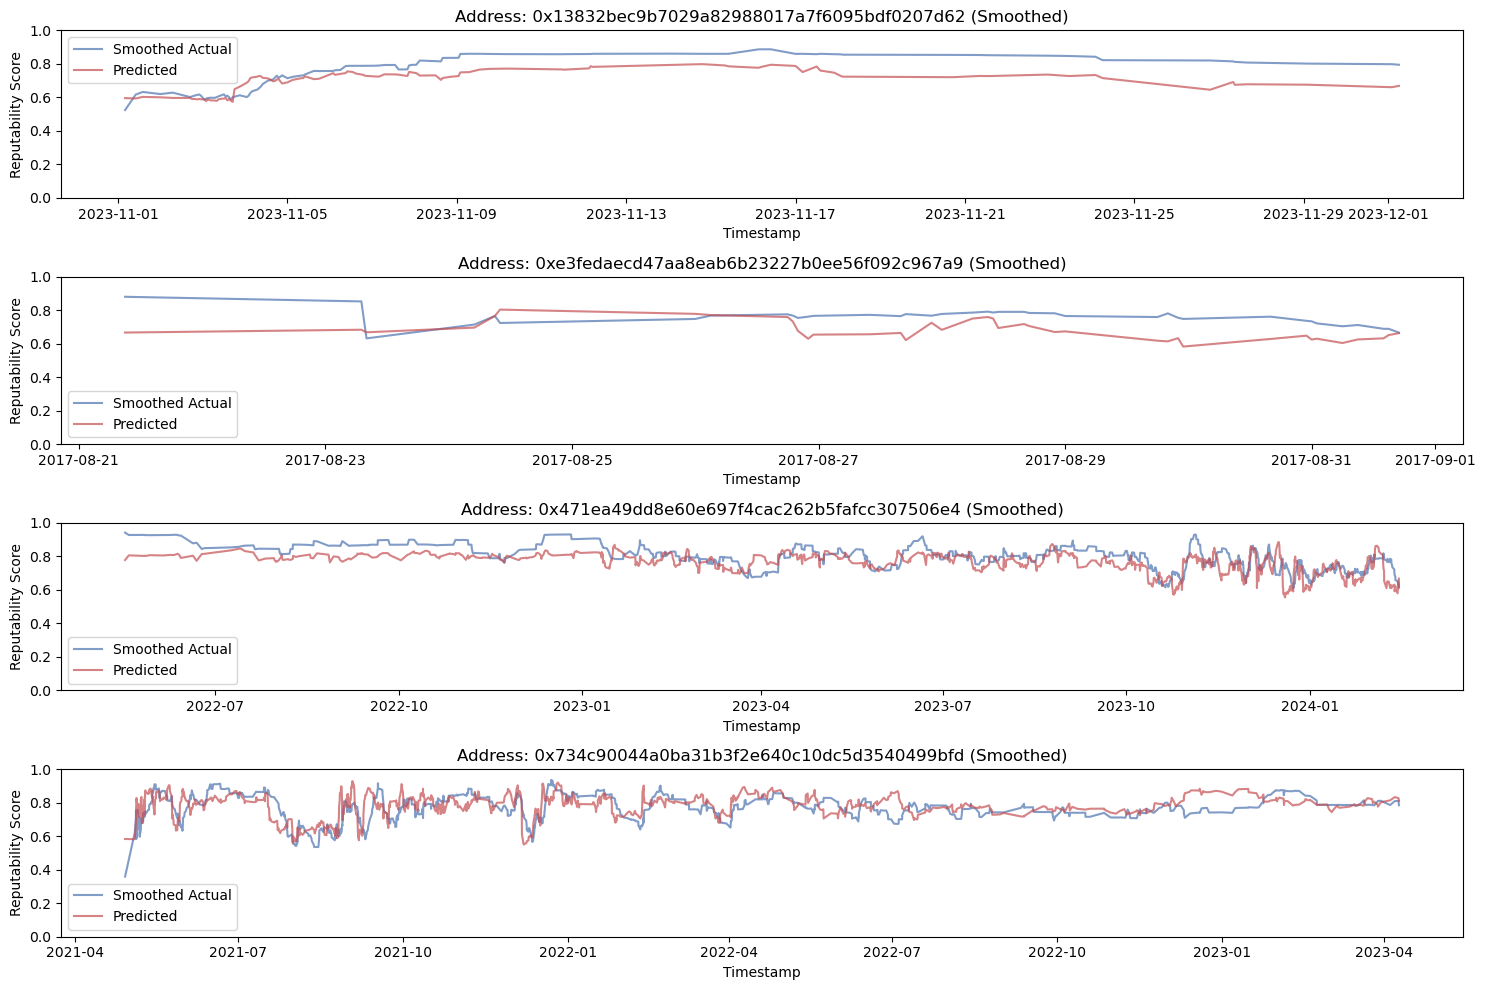

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
window_size = 25
smooth_window_size = 25  # Window size for smoothing
volatility_threshold = 0.05  # Adjust this based on acceptable volatility in reputability scores

# Sample addresses to plot
sample_addresses = [
    '0x13832bec9b7029a82988017a7f6095bdf0207d62',
    '0xe3fedaecd47aa8eab6b23227b0ee56f092c967a9',
    '0x471ea49dd8e60e697f4cac262b5fafcc307506e4',
    '0x734c90044a0ba31b3f2e640c10dc5d3540499bfd',
]

plt.figure(figsize=(15, 10))

# Plot for each address
for i, address in enumerate(sample_addresses):
    plt.subplot(len(sample_addresses), 1, i + 1)
    
    # Filter data for the specific address
    address_data = test_df[test_df['address'] == address]
    
    # Extract timestamps for x-axis
    tmp_addr_data = address_data.to_pandas()
    timestamps = pd.to_datetime(tmp_addr_data['timeStamp'])
    
    # Prepare sequences for the address
    X_address, y_address, _ = prepare_sequences_with_embeddings(address_data, window_size)
    X_address = X_address.reshape((X_address.shape[0], X_address.shape[1], 1))
    
    # Predict reputability scores
    y_pred_address = best_model.predict([X_address, np.full(X_address.shape[0], address_to_idx[address])])
    
    # Check for volatility in actual scores
    y_std = np.std(y_address)
    
    # Smoothen only if volatility is high
    if y_std > volatility_threshold:
        y_smooth = pd.Series(y_address).rolling(window=smooth_window_size, min_periods=1).mean()
        plt.plot(timestamps[:len(y_smooth)], y_smooth, label='Smoothed Actual', alpha=0.7, color='#4C72B0')
        plt.title(f'Address: {address} (Smoothed)')
    else:
        plt.plot(timestamps[:len(y_address)], y_address, label='Actual', alpha=0.7, color='blue')
        plt.title(f'Address: {address}')
    
    # Plot predicted scores
    plt.plot(timestamps[:len(y_pred_address)], y_pred_address, label='Predicted', alpha=0.7, color='#C44E52')

    plt.ylim(0, 1)
    
    # Labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Reputability Score')
    plt.legend()

plt.tight_layout()
plt.show()


In [39]:
df['rep_score'].isna().any()

False

In [6]:
from tensorflow.keras.models import load_model
import pandas as pd
csv_file = 'model_results_avg.csv'
df = pd.read_csv(csv_file)

# Find the row with the minimum validation loss
best_model_row = df.loc[df['Best Val Loss'].idxmin()]

# Extract the best hyperparameters
best_window_size = 25 # best_model_row['Window Size']
best_lstm_units = best_model_row['LSTM Units']
best_batch_size = best_model_row['Batch Size']
best_learning_rate = best_model_row['Learning Rate']

best_window_size = 25 # best_model_row['Window Size']
best_lstm_units = 128
best_batch_size = 32
best_learning_rate = 0.0005

print(f"Best Hyperparameters:\n"
      f"Window Size: {best_window_size}, "
      f"LSTM Units: {best_lstm_units}, "
      f"Batch Size: {best_batch_size}, "
      f"Learning Rate: {best_learning_rate}")

# Path to the best model's checkpoint
best_model_checkpoint_path = f"model_checkpoint_{best_window_size}_{best_lstm_units}_{best_batch_size}_{best_learning_rate}.keras"

# Path to the best model's checkpoint
best_model_checkpoint_path = f"model_checkpoint_{25}_{best_lstm_units}_{best_batch_size}_{best_learning_rate}.keras"

# Load the best model
if os.path.exists(best_model_checkpoint_path):
    best_model = load_model(best_model_checkpoint_path)
    print(f"Successfully loaded the best model from {best_model_checkpoint_path}")
else:
    print(f"Checkpoint file {best_model_checkpoint_path} not found.")

Best Hyperparameters:
Window Size: 25, LSTM Units: 128, Batch Size: 32, Learning Rate: 0.0005
Successfully loaded the best model from model_checkpoint_25_128_32_0.0005.keras


In [109]:
# Assuming you have your test data already prepared
X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(test_df, best_window_size)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model on the test set
test_loss = best_model.evaluate([X_test, contract_ids_test], y_test, verbose=1)
print(f"Test Loss: {test_loss}")

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 0.0447
Test Loss: 0.04634811356663704


In [110]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Generate predictions on the test set
y_pred = best_model.predict([X_test, contract_ids_test])
y_pred = y_pred.flatten()

# Calculate MSE between actual and predicted values (lag 0)
mse_lag_0 = mean_squared_error(y_test, y_pred)
print(f"MSE (No Lag): {mse_lag_0}")

# Calculate MSE for a lag of 1
# Shift the actual values by one time step and calculate the error
mse_lag_1 = mean_squared_error(y_test[1:], y_pred[:-1])
print(f"MSE (Lag 1): {mse_lag_1}")

# Calculate MSE for a lag of 2
mse_lag_2 = mean_squared_error(y_test[2:], y_pred[:-2])
print(f"MSE (Lag 2): {mse_lag_2}")


1212/1212 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step
MSE (No Lag): 0.046348106750238406
MSE (Lag 1): 0.04674740082354975
MSE (Lag 2): 0.0471053032707453


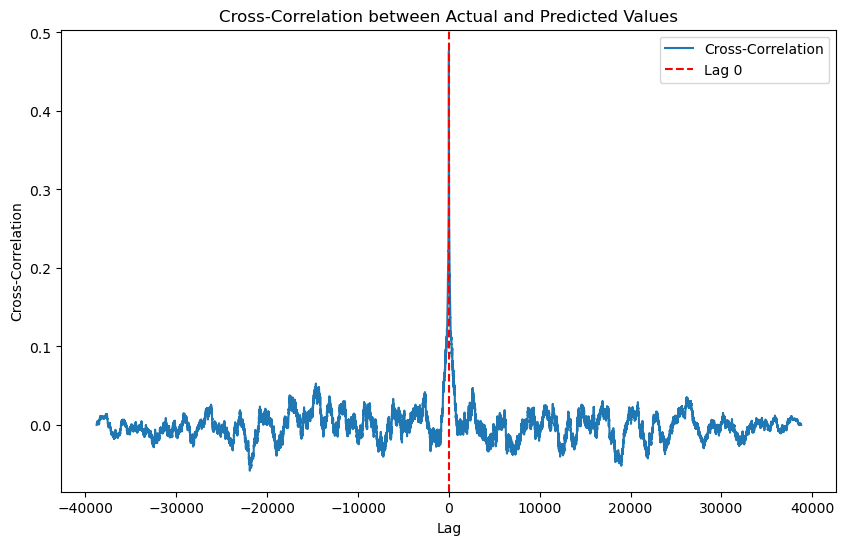

In [120]:
import matplotlib.pyplot as plt
from scipy.signal import correlate
import numpy as np

# Ensure y_test and y_pred have the same length
min_length = min(len(y_test), len(y_pred))
y_test_trimmed = y_test[:min_length]
y_pred_trimmed = y_pred[:min_length]

# Calculate cross-correlation between actual and predicted values
cross_corr = correlate(y_test_trimmed - np.mean(y_test_trimmed), y_pred_trimmed - np.mean(y_pred_trimmed), mode='full')
lags = np.arange(-len(y_test_trimmed) + 1, len(y_pred_trimmed))
cross_corr /= (np.std(y_test_trimmed) * np.std(y_pred_trimmed) * len(y_test_trimmed))

# Plot cross-correlation to see if the peak is at lag 0
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, label='Cross-Correlation')
plt.axvline(x=0, color='red', linestyle='--', label='Lag 0')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Actual and Predicted Values')
plt.legend()
plt.show()


In [121]:
# Calculate the direction of changes for actual and predicted values
actual_directions = np.sign(np.diff(y_test))
predicted_directions = np.sign(np.diff(y_pred))

# Calculate Trend Direction Accuracy
trend_direction_accuracy = np.mean(actual_directions == predicted_directions)
print(f"Trend Direction Accuracy: {trend_direction_accuracy * 100:.2f}%")
y_pred_trimmed.shape

Trend Direction Accuracy: 40.48%


(38771,)

In [30]:
# Generate predictions on the test set
predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

# Get actual values
actual_reputability_scores = y_test

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(actual_reputability_scores, predicted_reputability_scores)
mae = mean_absolute_error(actual_reputability_scores, predicted_reputability_scores)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE): 0.00117759826672155
Mean Absolute Error (MAE): 0.02384309734058029


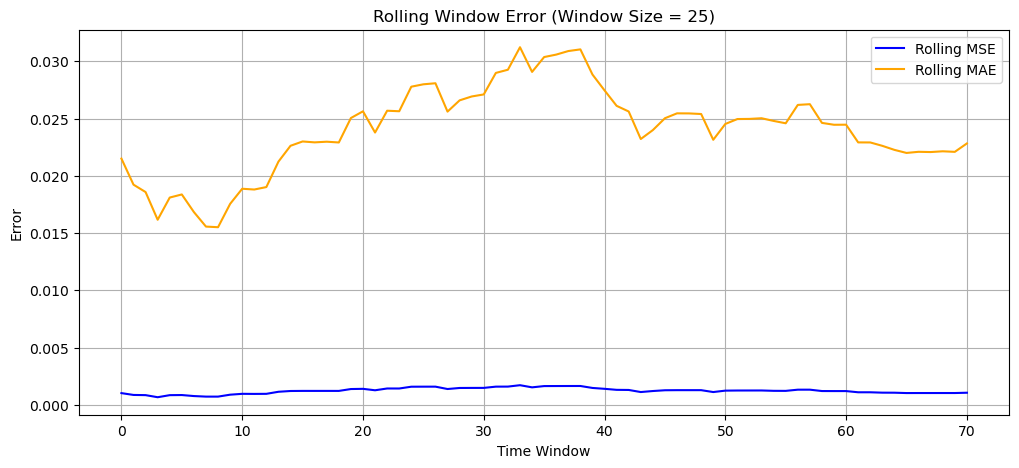

In [130]:
import numpy as np

def rolling_window_error(actual, predicted, window_size=24):
    rolling_mse = []
    rolling_mae = []
    for i in range(len(actual) - window_size + 1):
        window_actual = actual[i:i + window_size]
        window_predicted = predicted[i:i + window_size]
        window_mse = mean_squared_error(window_actual, window_predicted)
        window_mae = mean_absolute_error(window_actual, window_predicted)
        rolling_mse.append(window_mse)
        rolling_mae.append(window_mae)
    return rolling_mse, rolling_mae

# Calculate rolling errors
rolling_mse, rolling_mae = rolling_window_error(actual_reputability_scores, predicted_reputability_scores, window_size=30)

# Plot Rolling MSE and MAE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(rolling_mse, label='Rolling MSE', color='blue')
plt.plot(rolling_mae, label='Rolling MAE', color='orange')
plt.xlabel('Time Window')
plt.ylabel('Error')
plt.title(f'Rolling Window Error (Window Size = 25)')
plt.legend()
plt.grid(True)
plt.show()


Number of abrupt changes (spikes): 0


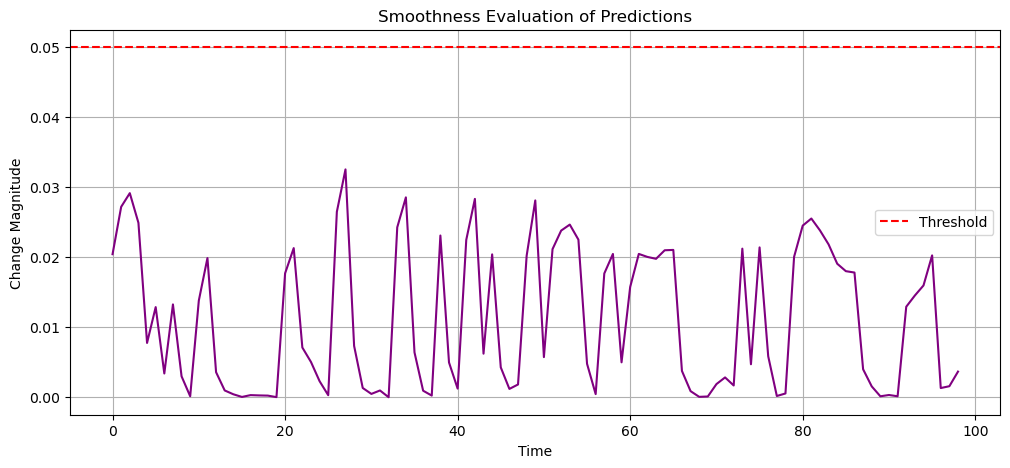

In [34]:
# Calculate the smoothness of predictions
smoothness = np.abs(np.diff(predicted_reputability_scores))

# Set a threshold to count as "spikes" (adjust based on expected smoothness of your trend)
threshold = 0.05
num_spikes = np.sum(smoothness > threshold)

print(f"Number of abrupt changes (spikes): {num_spikes}")

# Plot smoothness to visually assess volatility
plt.figure(figsize=(12, 5))
plt.plot(smoothness, color='purple')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Time')
plt.ylabel('Change Magnitude')
plt.title('Smoothness Evaluation of Predictions')
plt.legend()
plt.grid(True)
plt.show()


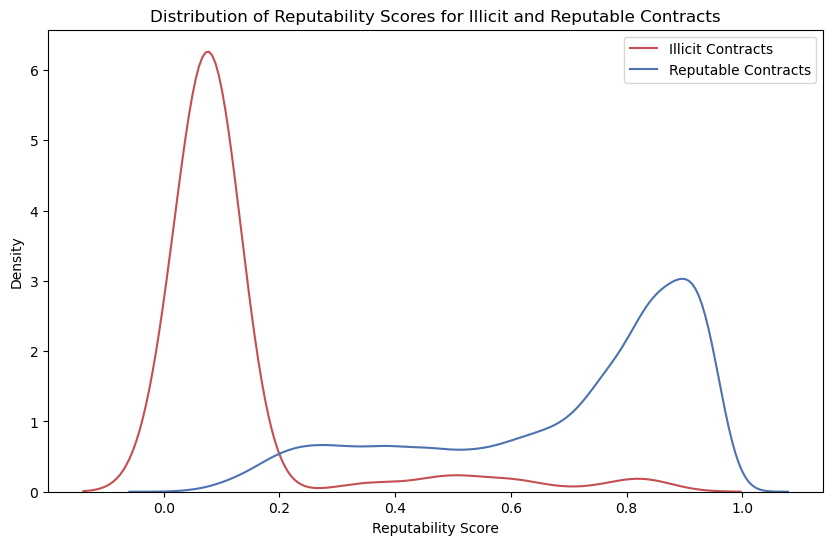

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have two arrays: illicit_scores and reputable_scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['rep_score'][df['contract_status'] == 0], color="#C44E52", label="Illicit Contracts")
sns.kdeplot(df['rep_score'][df['contract_status'] == 1], color="#4C72B0",label="Reputable Contracts")
plt.xlabel("Reputability Score")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Reputability Scores for Illicit and Reputable Contracts")
plt.show()


In [135]:
test_df['address'][test_df['contract_status'] == 1].value_counts()

address
0xc28e931814725bbeb9e670676fabbcb694fe7df2    3754
0xec5483804e637d45cde22fa0869656b64b5ab1ab    3185
0x370a366f402e2e41cdbbe54ecec12aae0cce1955    2262
0x80ce3027a70e0a928d9268994e9b85d03bd4cdcf    2184
0x6c936d4ae98e6d2172db18c16c4b601c99918ee6    2009
0xd101dcc414f310268c37eeb4cd376ccfa507f571    1797
0x111111517e4929d3dcbdfa7cce55d30d4b6bc4d6    1755
0x36ac219f90f5a6a3c77f2a7b660e3cc701f68e25    1729
0xd7f0cc50ad69408ae58be033f4f85d2367c2e468    1513
0x220b71671b649c03714da9c621285943f3cbcdc6    1510
0x734c90044a0ba31b3f2e640c10dc5d3540499bfd    1419
0x471ea49dd8e60e697f4cac262b5fafcc307506e4    1372
0x3c9d6c1c73b31c837832c72e04d3152f051fc1a9    1248
0x009668a9691e456972c8ec4cc84e99486308b84d    1153
0xd01409314acb3b245cea9500ece3f6fd4d70ea30    1132
0xda23d301761e4e2bf474951f978f6dfb6f3c9f14    1118
0x59c6766de1dc50a9c9db86cb0461b5ce07408ab7    1042
0x5c8190b76e90b4dd0702740cf6eb0f7ee01ab5e9    1001
0x43a96962254855f16b925556f9e97be436a43448     861
0x9b81686140e85d28c2236

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


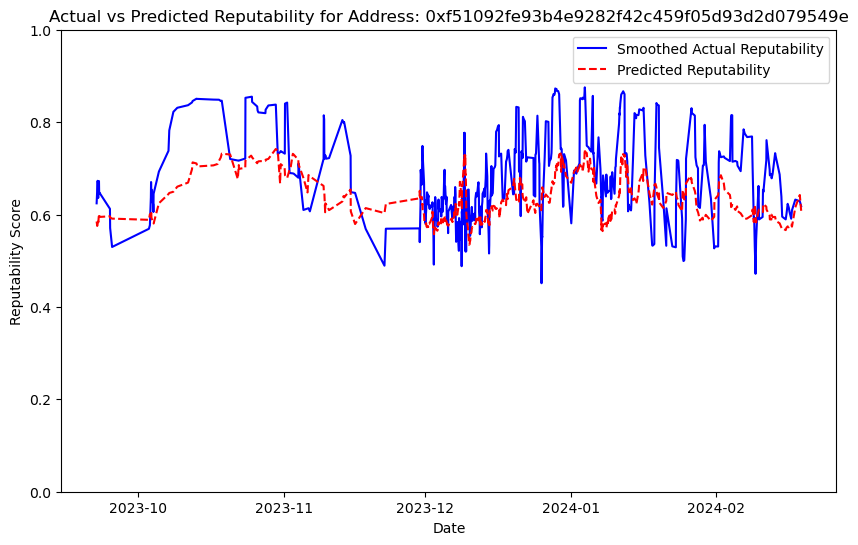

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model

# Assuming test_df is a cuDF DataFrame and the best model is available

# Select a specific address from the test set
selected_address = '0xf51092fe93b4e9282f42c459f05d93d2d079549e'  # Replace with any address from test_df

# Filter the data for the selected address
address_test_data = test_df[test_df['address'] == selected_address]

# Prepare the sequence data for the selected address
X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)

# Reshape the inputs if necessary (based on the original model's input shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Load the best model
best_model_checkpoint_path = f"model_checkpoint_{best_window_size}_{best_lstm_units}_{best_batch_size}_{best_learning_rate}.keras"
best_model = load_model(best_model_checkpoint_path)

# Make predictions for the selected address
predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

# Convert the predictions and actual values to pandas for easy plotting
actual_reputability_scores = pd.Series(y_test)
predicted_reputability_scores = pd.Series(predicted_reputability_scores)

# Apply rolling average (smoothing) to the actual scores
smooth_window = 5  # Define your smoothing window size here
smoothed_actual_scores = actual_reputability_scores.rolling(window=smooth_window, min_periods=1).mean()

# Ensure the lengths match (since prediction might be shorter due to window size)
num_predictions = len(predicted_reputability_scores)
address_test_data_sliced = address_test_data.iloc[best_window_size:num_predictions + best_window_size].to_pandas()

# Convert timeStamp to datetime for plotting
address_test_data_sliced['timeStamp'] = pd.to_datetime(address_test_data_sliced['timeStamp'])

# Plot Actual vs Predicted Reputability Scores
plt.figure(figsize=(10, 6))

# Plot smoothed actual reputability scores
plt.plot(address_test_data_sliced['timeStamp'], smoothed_actual_scores[:num_predictions], label='Smoothed Actual Reputability', color='blue')

# Plot predicted reputability scores
plt.plot(address_test_data_sliced['timeStamp'], predicted_reputability_scores, label='Predicted Reputability', color='red', linestyle='--')

plt.ylim(0,1)
# Labels and title
plt.xlabel('Date')
plt.ylabel('Reputability Score')
plt.title(f'Actual vs Predicted Reputability for Address: {selected_address}')
plt.legend()

# Show the plot
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


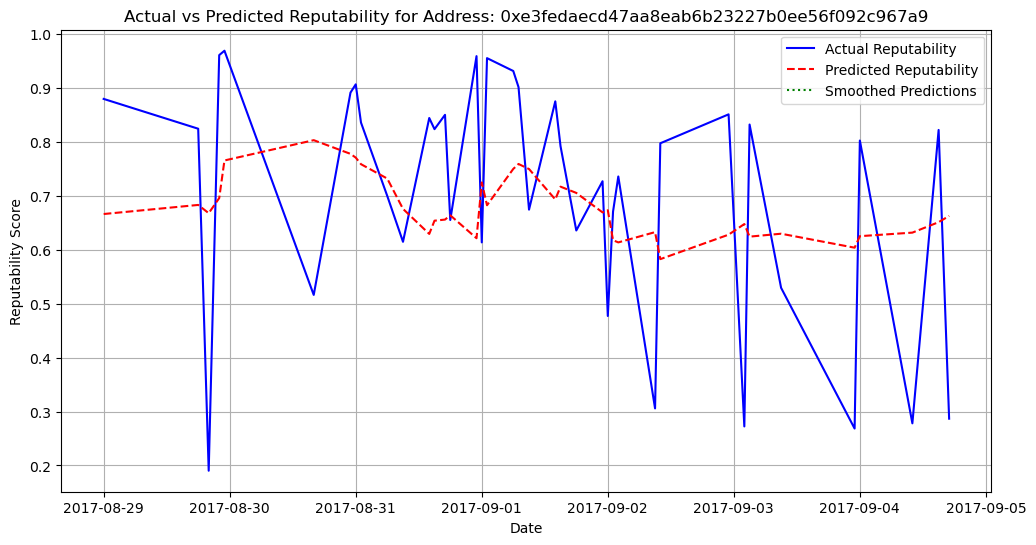

In [81]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

def plot_reputability_comparison(selected_address, test_df, best_model_checkpoint_path, best_window_size):
    # Filter the data for the selected address
    address_test_data = test_df[test_df['address'] == selected_address]

    # Prepare the sequence data for the selected address
    X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)
    
    # Reshape if necessary (ensure compatibility with model input shape)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Load the best model
    best_model = load_model(best_model_checkpoint_path)

    # Make predictions
    predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()
    actual_reputability_scores = y_test

    # Match lengths (prediction might be shorter due to window size)
    num_predictions = len(predicted_reputability_scores)
    address_test_data_sliced = address_test_data.iloc[best_window_size:num_predictions + best_window_size].to_pandas()

    # Convert timeStamp to datetime for plotting
    address_test_data_sliced['timeStamp'] = pd.to_datetime(address_test_data_sliced['timeStamp'])

    # Plot Actual vs Predicted Reputability Scores
    plt.figure(figsize=(12, 6))
    plt.plot(address_test_data_sliced['timeStamp'], actual_reputability_scores[:num_predictions], label='Actual Reputability', color='blue')
    plt.plot(address_test_data_sliced['timeStamp'], predicted_reputability_scores, label='Predicted Reputability', color='red', linestyle='--')
    
    # Optional Moving Average for Predicted Scores
    address_test_data_sliced['Smoothed Predictions'] = pd.Series(predicted_reputability_scores).rolling(window=10).mean()
    plt.plot(address_test_data_sliced['timeStamp'], address_test_data_sliced['Smoothed Predictions'], label='Smoothed Predictions', color='green', linestyle=':')

    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Reputability Score')
    plt.title(f'Actual vs Predicted Reputability for Address: {selected_address}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
selected_address = '0xe3fedaecd47aa8eab6b23227b0ee56f092c967a9'
best_model_checkpoint_path = f"model_checkpoint_{best_window_size}_{best_lstm_units}_{best_batch_size}_{best_learning_rate}.keras"
plot_reputability_comparison(selected_address, test_df, best_model_checkpoint_path, best_window_size)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


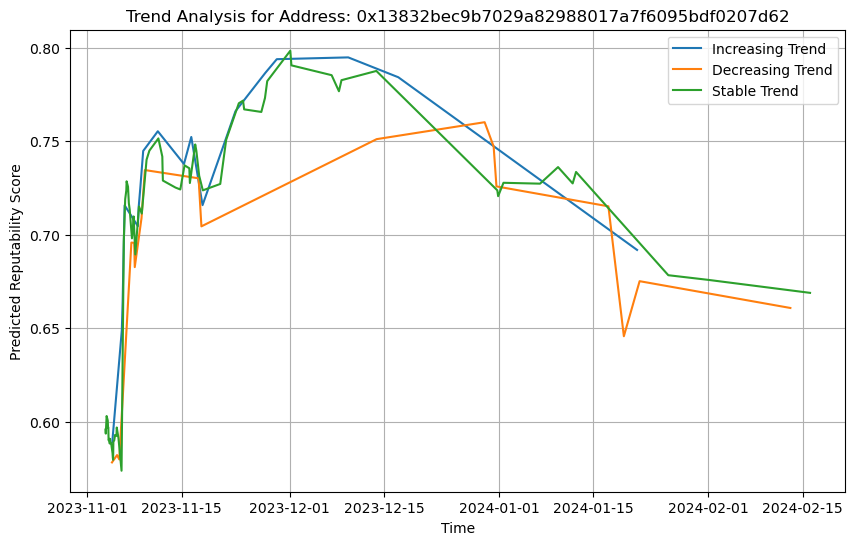

In [84]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

def plot_trend_analysis(test_df, selected_address, best_model_checkpoint_path, best_window_size, threshold=0.01):
    # Filter and prepare data
    address_test_data = test_df[test_df['address'] == selected_address]
    X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Load model and make predictions
    best_model = load_model(best_model_checkpoint_path)
    predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

    # Slice data for plotting
    num_predictions = len(predicted_reputability_scores)
    address_test_data_sliced = address_test_data.iloc[best_window_size:num_predictions + best_window_size].to_pandas()
    address_test_data_sliced['timeStamp'] = pd.to_datetime(address_test_data_sliced['timeStamp'])
    address_test_data_sliced['predicted_reputability_scores'] = predicted_reputability_scores

    # Determine trend categories
    address_test_data_sliced['trend'] = address_test_data_sliced['predicted_reputability_scores'].diff()
    address_test_data_sliced['Trend Category'] = address_test_data_sliced['trend'].apply(
        lambda x: 'Increasing' if x > threshold else 'Decreasing' if x < -threshold else 'Stable'
    )

    # Plot each trend category
    plt.figure(figsize=(10, 6))
    for trend_type in ['Increasing', 'Decreasing', 'Stable']:
        trend_data = address_test_data_sliced[address_test_data_sliced['Trend Category'] == trend_type]
        plt.plot(trend_data['timeStamp'], trend_data['predicted_reputability_scores'], label=f'{trend_type} Trend')
    
    plt.xlabel('Time')
    plt.ylabel('Predicted Reputability Score')
    plt.title(f'Trend Analysis for Address: {selected_address}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example
plot_trend_analysis(test_df, selected_address='0x13832bec9b7029a82988017a7f6095bdf0207d62', 
                    best_model_checkpoint_path=best_model_checkpoint_path, 
                    best_window_size=best_window_size)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


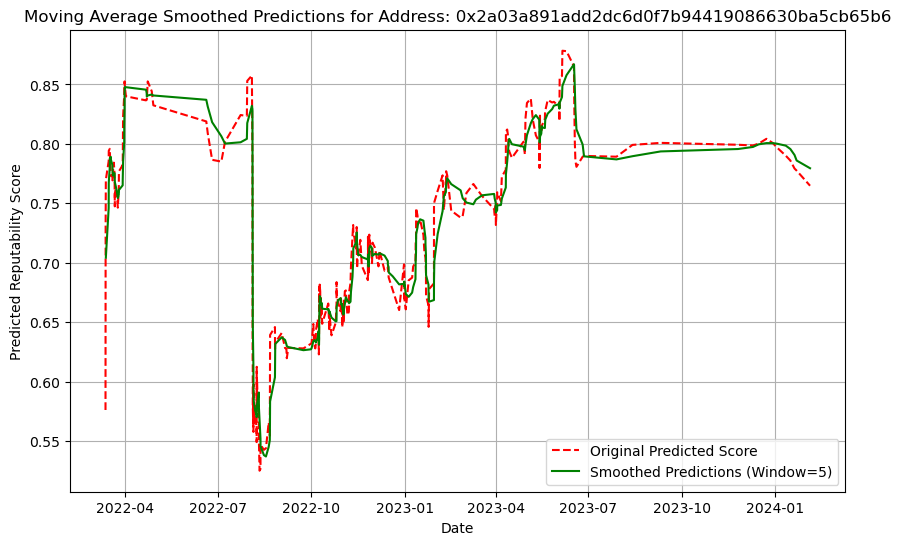

In [87]:
def plot_moving_average(test_df, selected_address, best_model_checkpoint_path, best_window_size, window_size=5):
    address_test_data = test_df[test_df['address'] == selected_address]
    X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Load model and make predictions
    best_model = load_model(best_model_checkpoint_path)
    predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

    # Prepare data for plotting
    num_predictions = len(predicted_reputability_scores)
    address_test_data_sliced = address_test_data.iloc[best_window_size:num_predictions + best_window_size].to_pandas()
    address_test_data_sliced['timeStamp'] = pd.to_datetime(address_test_data_sliced['timeStamp'])
    address_test_data_sliced['predicted_reputability_scores'] = predicted_reputability_scores

    # Apply moving average
    address_test_data_sliced['Smoothed Predictions'] = address_test_data_sliced['predicted_reputability_scores'].rolling(window=window_size).mean()

    # Plot original vs. smoothed predictions
    plt.figure(figsize=(10, 6))
    plt.plot(address_test_data_sliced['timeStamp'], address_test_data_sliced['predicted_reputability_scores'], label='Original Predicted Score', color='red', linestyle='--')
    plt.plot(address_test_data_sliced['timeStamp'], address_test_data_sliced['Smoothed Predictions'], label=f'Smoothed Predictions (Window={window_size})', color='green')
    plt.xlabel('Date')
    plt.ylabel('Predicted Reputability Score')
    plt.title(f'Moving Average Smoothed Predictions for Address: {selected_address}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example
plot_moving_average(test_df, selected_address='0x2a03a891add2dc6d0f7b94419086630ba5cb65b6', 
                    best_model_checkpoint_path=best_model_checkpoint_path, 
                    best_window_size=best_window_size)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


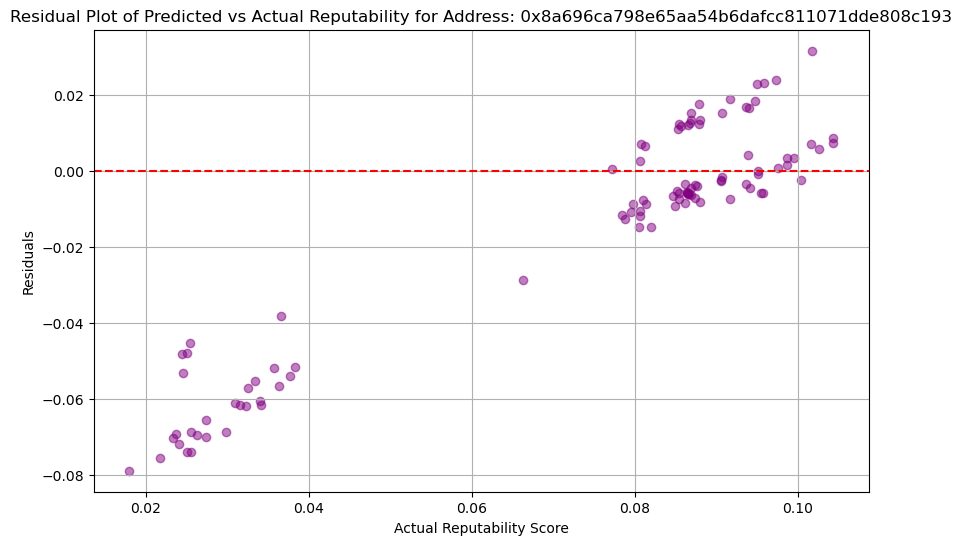

In [20]:
def plot_residuals(test_df, selected_address, best_model_checkpoint_path, best_window_size):
    address_test_data = test_df[test_df['address'] == selected_address]
    X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Load model and make predictions
    best_model = load_model(best_model_checkpoint_path)
    predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

    # Prepare data for plotting
    num_predictions = len(predicted_reputability_scores)
    address_test_data_sliced = address_test_data.iloc[best_window_size:num_predictions + best_window_size].to_pandas()
    address_test_data_sliced['actual_reputability_scores'] = y_test[:num_predictions]
    address_test_data_sliced['predicted_reputability_scores'] = predicted_reputability_scores

    # Calculate residuals
    address_test_data_sliced['residuals'] = address_test_data_sliced['actual_reputability_scores'] - address_test_data_sliced['predicted_reputability_scores']

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(address_test_data_sliced['actual_reputability_scores'], address_test_data_sliced['residuals'], alpha=0.5, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Reputability Score')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot of Predicted vs Actual Reputability for Address: {selected_address}')
    plt.grid(True)
    plt.show()

# Usage example
plot_residuals(test_df, selected_address='0x8a696ca798e65aa54b6dafcc811071dde808c193', 
               best_model_checkpoint_path=best_model_checkpoint_path, 
               best_window_size=best_window_size)


In [26]:
test_df['address'][test_df['contract_status'] == 1].value_counts()

address
0xc28e931814725bbeb9e670676fabbcb694fe7df2    3754
0xec5483804e637d45cde22fa0869656b64b5ab1ab    3185
0x370a366f402e2e41cdbbe54ecec12aae0cce1955    2262
0x80ce3027a70e0a928d9268994e9b85d03bd4cdcf    2184
0x6c936d4ae98e6d2172db18c16c4b601c99918ee6    2009
0xd101dcc414f310268c37eeb4cd376ccfa507f571    1797
0x111111517e4929d3dcbdfa7cce55d30d4b6bc4d6    1755
0x36ac219f90f5a6a3c77f2a7b660e3cc701f68e25    1729
0xd7f0cc50ad69408ae58be033f4f85d2367c2e468    1513
0x220b71671b649c03714da9c621285943f3cbcdc6    1510
0x734c90044a0ba31b3f2e640c10dc5d3540499bfd    1419
0x471ea49dd8e60e697f4cac262b5fafcc307506e4    1372
0x3c9d6c1c73b31c837832c72e04d3152f051fc1a9    1248
0x009668a9691e456972c8ec4cc84e99486308b84d    1153
0xd01409314acb3b245cea9500ece3f6fd4d70ea30    1132
0xda23d301761e4e2bf474951f978f6dfb6f3c9f14    1118
0x59c6766de1dc50a9c9db86cb0461b5ce07408ab7    1042
0x5c8190b76e90b4dd0702740cf6eb0f7ee01ab5e9    1001
0x43a96962254855f16b925556f9e97be436a43448     861
0x9b81686140e85d28c2236

In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

def calculate_trend_accuracy(test_df, selected_address, best_model_checkpoint_path, best_window_size, threshold=0.01):
    # Filter and prepare data
    address_test_data = test_df[test_df['address'] == selected_address]
    X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(address_test_data, best_window_size)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Load model and make predictions
    best_model = load_model(best_model_checkpoint_path)
    predicted_reputability_scores = best_model.predict([X_test, contract_ids_test]).flatten()

    # Prepare data for trend comparison
    num_predictions = len(predicted_reputability_scores)
    actual_reputability_scores = y_test[:num_predictions]
    
    # Define trends for actual and predicted scores
    actual_trends = np.where(np.diff(actual_reputability_scores) > threshold, 'Increasing',
                             np.where(np.diff(actual_reputability_scores) < -threshold, 'Decreasing', 'Stable'))
    predicted_trends = np.where(np.diff(predicted_reputability_scores) > threshold, 'Increasing',
                                np.where(np.diff(predicted_reputability_scores) < -threshold, 'Decreasing', 'Stable'))
    
    # Compare trends and calculate accuracy
    trend_matches = actual_trends == predicted_trends
    trend_accuracy = np.mean(trend_matches)
    
    # Print summary
    print(f"Trend Accuracy for Address {selected_address}: {trend_accuracy * 100:.2f}%")
    return trend_accuracy

# Usage example
trend_accuracy = calculate_trend_accuracy(test_df, selected_address='0x59c6766de1dc50a9c9db86cb0461b5ce07408ab7', 
                                          best_model_checkpoint_path=best_model_checkpoint_path, 
                                          best_window_size=best_window_size)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Trend Accuracy for Address 0x59c6766de1dc50a9c9db86cb0461b5ce07408ab7: 26.08%


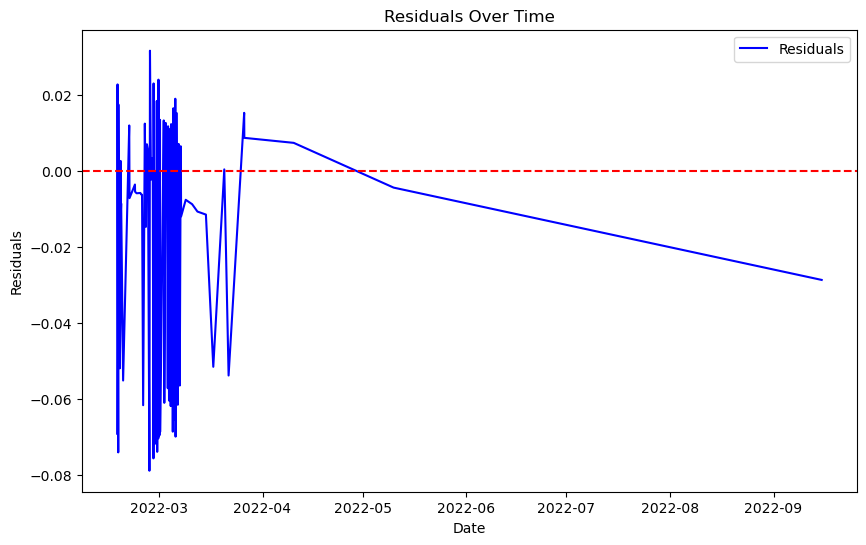

In [10]:
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame with columns 'Date', 'Actual Reputability', and 'Predicted Reputability'
address_test_data_sliced['Residual'] = actual_reputability_scores[:num_predictions] - predicted_reputability_scores

plt.figure(figsize=(10, 6))
plt.plot(address_test_data_sliced['timeStamp'], address_test_data_sliced['Residual'], color='blue', label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()


In [19]:
print("Mean Residual:", address_test_data_sliced['Residual'].mean())
print("Standard Deviation of Residuals:", address_test_data_sliced['Residual'].std())


Mean Residual: 0.039753606898550564
Standard Deviation of Residuals: 0.16905052755228883


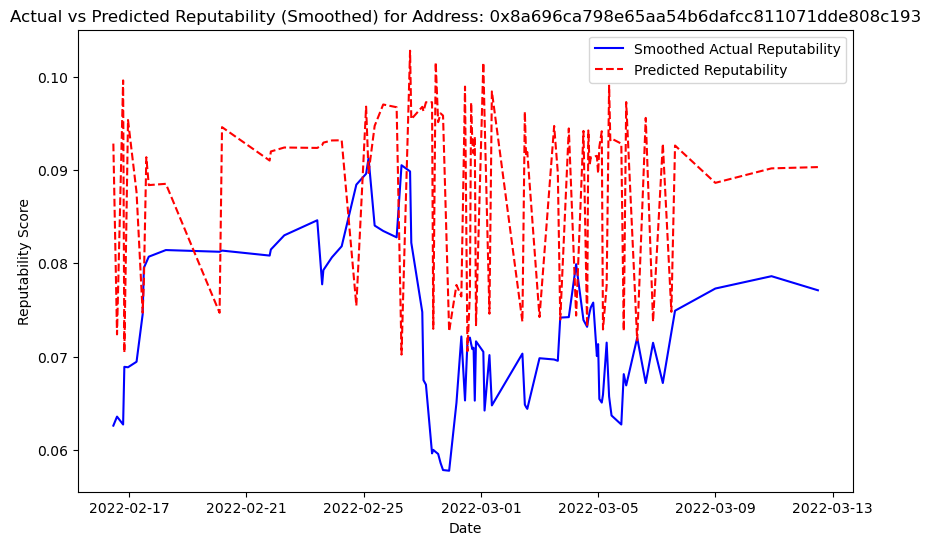

In [11]:
import numpy as np

# Define a window size for smoothing
smoothing_window = 10 # Adjust this for more or less smoothing

# Use numpy's convolve function to apply moving average
smoothed_actual_reputability_scores = np.convolve(actual_reputability_scores, np.ones(smoothing_window)/smoothing_window, mode='valid')

# Adjust the timestamps to match the smoothed data
address_test_data_sliced_smoothed = address_test_data_sliced.iloc[:len(smoothed_actual_reputability_scores)]

# Plot Actual vs Predicted Reputability Scores with Smoothed Actual Values
plt.figure(figsize=(10, 6))

# Plot smoothed actual reputability scores
plt.plot(address_test_data_sliced_smoothed['timeStamp'], smoothed_actual_reputability_scores, label='Smoothed Actual Reputability', color='blue')

# Plot predicted reputability scores (sliced to match the length of the smoothed data)
plt.plot(address_test_data_sliced_smoothed['timeStamp'], predicted_reputability_scores[:len(smoothed_actual_reputability_scores)], label='Predicted Reputability', color='red', linestyle='--')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Reputability Score')
plt.title(f'Actual vs Predicted Reputability (Smoothed) for Address: {selected_address}')
plt.legend()

# Show the plot
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE between smoothed actual reputability scores and predicted reputability scores
mse = mean_squared_error(smoothed_actual_reputability_scores, predicted_reputability_scores[:len(smoothed_actual_reputability_scores)])

# Calculate MAE between smoothed actual reputability scores and predicted reputability scores
mae = mean_absolute_error(smoothed_actual_reputability_scores, predicted_reputability_scores[:len(smoothed_actual_reputability_scores)])

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.00036330097787185933
Mean Absolute Error (MAE): 0.01606172521725675


In [68]:
def calculate_lead_time(predicted_scores, actual_scores, time_stamps, threshold=0.5):
    lead_times = []
    for i, (pred_scores, actual_scores_contract) in enumerate(zip(predicted_scores, actual_scores)):
        actual_non_reputable_idx = np.where(actual_scores_contract < threshold)[0]
        pred_non_reputable_idx = np.where(pred_scores < threshold)[0]
        
        if len(actual_non_reputable_idx) > 0 and len(pred_non_reputable_idx) > 0:
            first_actual = actual_non_reputable_idx[0]
            first_pred = pred_non_reputable_idx[0]
            
            # Calculate the time difference
            lead_time = (time_stamps[i][first_actual] - time_stamps[i][first_pred]).total_seconds() / 3600  # convert to hours
            lead_times.append(lead_time)

    return np.mean(lead_times), lead_times


In [69]:
import matplotlib.pyplot as plt

def plot_time_to_event_curve(predicted_scores, actual_scores, time_stamps, threshold=0.5):
    times = []
    fractions_predicted = []
    fractions_actual = []
    
    # Time range (e.g., in hours or days)
    unique_times = sorted(set([t for sublist in time_stamps for t in sublist]))
    
    for t in unique_times:
        pred_non_reputable = 0
        actual_non_reputable = 0
        total_contracts = len(predicted_scores)

        for i in range(total_contracts):
            # Find the score at the current time t
            pred_idx = np.where(time_stamps[i] == t)[0]
            if len(pred_idx) > 0:
                pred_score = predicted_scores[i][pred_idx[0]]
                actual_score = actual_scores[i][pred_idx[0]]
                
                if pred_score < threshold:
                    pred_non_reputable += 1
                if actual_score < threshold:
                    actual_non_reputable += 1

        fractions_predicted.append(1 - pred_non_reputable / total_contracts)
        fractions_actual.append(1 - actual_non_reputable / total_contracts)
        times.append(t)

    # Plot the curves
    plt.figure(figsize=(10, 6))
    plt.plot(times, fractions_predicted, label='Predicted Reputability', linestyle='--')
    plt.plot(times, fractions_actual, label='Actual Reputability', linestyle='-')
    plt.title('Time-to-Event Curve (Reputability Over Time)')
    plt.xlabel('Time')
    plt.ylabel('Fraction of Contracts Still Reputable')
    plt.legend()
    plt.show()

def plot_predicted_vs_actual(predicted_scores, actual_scores, time_stamps, contract_idx):
    plt.figure(figsize=(10, 6))
    plt.plot(time_stamps[contract_idx], predicted_scores[contract_idx], label='Predicted Reputability')
    plt.plot(time_stamps[contract_idx], actual_scores[contract_idx], label='Actual Reputability', linestyle='--')
    plt.title(f'Reputability Over Time for Contract {contract_idx}')
    plt.xlabel('Time')
    plt.ylabel('Reputability Score')
    plt.legend()
    plt.show()


1178/1178 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Skipping contract 0 due to index out of bounds
Average Lead Time: None hours


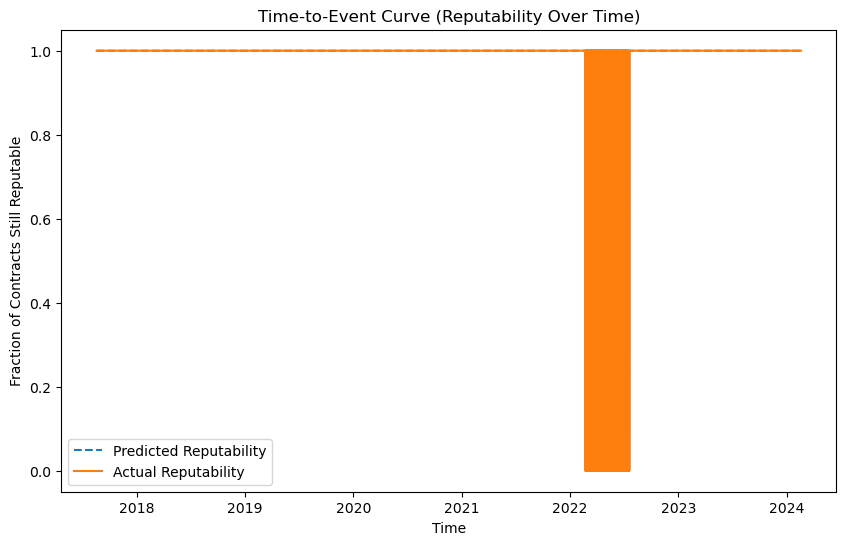

ValueError: x and y must have same first dimension, but have shapes (1153,) and (37696, 1)

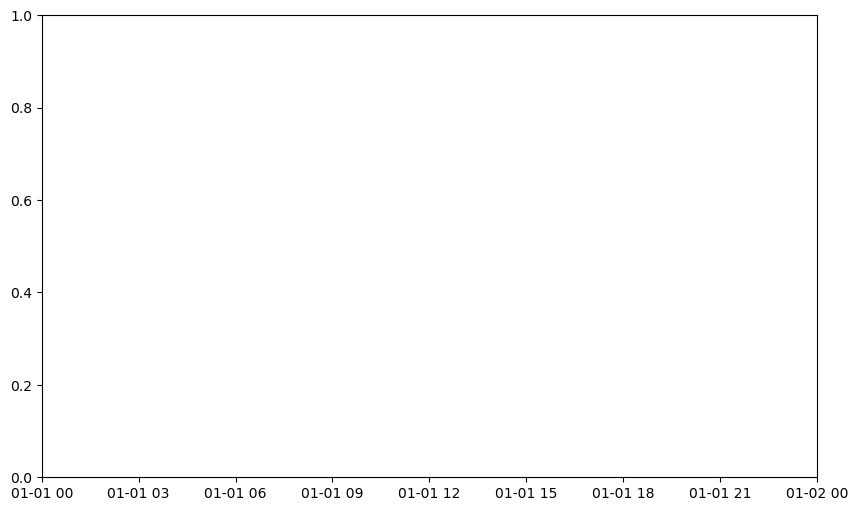

In [94]:
from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
def calculate_lead_time(predicted_scores, actual_scores, time_stamps, threshold=0.3):
    lead_times = []
    for i, (pred_scores, actual_scores_contract) in enumerate(zip(predicted_scores, actual_scores)):
        actual_non_reputable_idx = np.where(actual_scores_contract < threshold)[0]
        pred_non_reputable_idx = np.where(pred_scores < threshold)[0]

        if len(actual_non_reputable_idx) > 0 and len(pred_non_reputable_idx) > 0:
            first_actual = actual_non_reputable_idx[0]
            first_pred = pred_non_reputable_idx[0]
            
            # Ensure that the indices are within bounds of the time_stamps array
            if first_actual < len(time_stamps[i]) and first_pred < len(time_stamps[i]):
                # Calculate the time difference
                lead_time = (time_stamps[i][first_actual] - time_stamps[i][first_pred]).total_seconds() / 3600  # convert to hours
                lead_times.append(lead_time)
            else:
                print(f"Skipping contract {i} due to index out of bounds")

    if lead_times:
        return np.mean(lead_times), lead_times
    else:
        return None, []


# Time-to-Event Curve Function
def plot_time_to_event_curve(predicted_scores, actual_scores, time_stamps, threshold=0.3):
    times = []
    fractions_predicted = []
    fractions_actual = []

    unique_times = sorted(set([t for sublist in time_stamps for t in sublist]))

    for t in unique_times:
        pred_non_reputable = 0
        actual_non_reputable = 0
        total_contracts = len(predicted_scores)

        for i in range(total_contracts):
            pred_idx = np.where(time_stamps[i] == t)[0]
            if len(pred_idx) > 0:
                pred_score = predicted_scores[i][pred_idx[0]]
                actual_score = actual_scores[i][pred_idx[0]]

                if pred_score < threshold:
                    pred_non_reputable += 1
                if actual_score < threshold:
                    actual_non_reputable += 1

        fractions_predicted.append(1 - pred_non_reputable / total_contracts)
        fractions_actual.append(1 - actual_non_reputable / total_contracts)
        times.append(t)

    # Plot the curves
    plt.figure(figsize=(10, 6))
    plt.plot(times, fractions_predicted, label='Predicted Reputability', linestyle='--')
    plt.plot(times, fractions_actual, label='Actual Reputability', linestyle='-')
    plt.title('Time-to-Event Curve (Reputability Over Time)')
    plt.xlabel('Time')
    plt.ylabel('Fraction of Contracts Still Reputable')
    plt.legend()
    plt.show()

# Time-based Precision, Recall, and F1-Score
def calculate_time_based_metrics(predicted_scores, actual_scores, time_stamps, threshold=0.3):
    precisions = []
    recalls = []
    f1_scores = []
    times = []

    unique_times = sorted(set([t for sublist in time_stamps for t in sublist]))

    for t in unique_times:
        preds = []
        actuals = []

        for i in range(len(predicted_scores)):
            idx = np.where(time_stamps[i] == t)[0]
            if len(idx) > 0:
                preds.append(int(predicted_scores[i][idx[0]] < threshold))
                actuals.append(int(actual_scores[i][idx[0]] < threshold))

        precisions.append(precision_score(actuals, preds))
        recalls.append(recall_score(actuals, preds))
        f1_scores.append(f1_score(actuals, preds))
        times.append(t)

    return precisions, recalls, f1_scores, times

# Visualization of Forecasted Reputability Scores
def plot_predicted_vs_actual(predicted_scores, actual_scores, time_stamps, contract_idx):
    plt.figure(figsize=(10, 6))
    plt.plot(time_stamps[contract_idx], predicted_scores[contract_idx], label='Predicted Reputability')
    plt.plot(time_stamps[contract_idx], actual_scores[contract_idx], label='Actual Reputability', linestyle='--')
    plt.title(f'Reputability Over Time for Contract {contract_idx}')
    plt.xlabel('Time')
    plt.ylabel('Reputability Score')
    plt.legend()
    plt.show()

# Prepare the test set sequences and embeddings
window_size = 50  # Choose the window size that performed best
X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(test_df, window_size)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # 1 feature (rep_score)

# Convert cuDF DataFrame to pandas for handling timeStamp
test_df_pandas = test_df.to_pandas()

# Convert timeStamp to datetime if necessary
test_df_pandas['timeStamp'] = pd.to_datetime(test_df_pandas['timeStamp'])

# Extract time stamps for each address
test_time_stamps = [test_df_pandas[test_df_pandas['address'] == addr]['timeStamp'].values for addr in test_df_pandas['address'].unique()]

# Predict on the test set
y_pred_test = best_model.predict([X_test, contract_ids_test])

# Calculate Lead Time
average_lead_time, lead_times = calculate_lead_time([y_pred_test], [y_test], test_time_stamps, threshold=0.5)
print(f"Average Lead Time: {average_lead_time} hours")

# Plot Time-to-Event Curve
plot_time_to_event_curve([y_pred_test], [y_test], test_time_stamps, threshold=0.5)

# # Calculate Precision, Recall, and F1-Score over Time
# precisions, recalls, f1_scores, times = calculate_time_based_metrics([y_pred_test], [y_test], test_time_stamps, threshold=0.5)

# # Plot precision, recall, and F1-scores over time
# plt.figure(figsize=(10, 6))
# plt.plot(times, precisions, label='Precision', linestyle='-')
# plt.plot(times, recalls, label='Recall', linestyle='--')
# plt.plot(times, f1_scores, label='F1 Score', linestyle=':')
# plt.title('Precision, Recall, and F1 Score Over Time')
# plt.xlabel('Time')
# plt.ylabel('Metric')
# plt.legend()
# plt.show()

# Plot predicted vs actual reputability for a specific contract (index 0 for example)
plot_predicted_vs_actual([y_pred_test], [y_test], test_time_stamps, contract_idx=0)

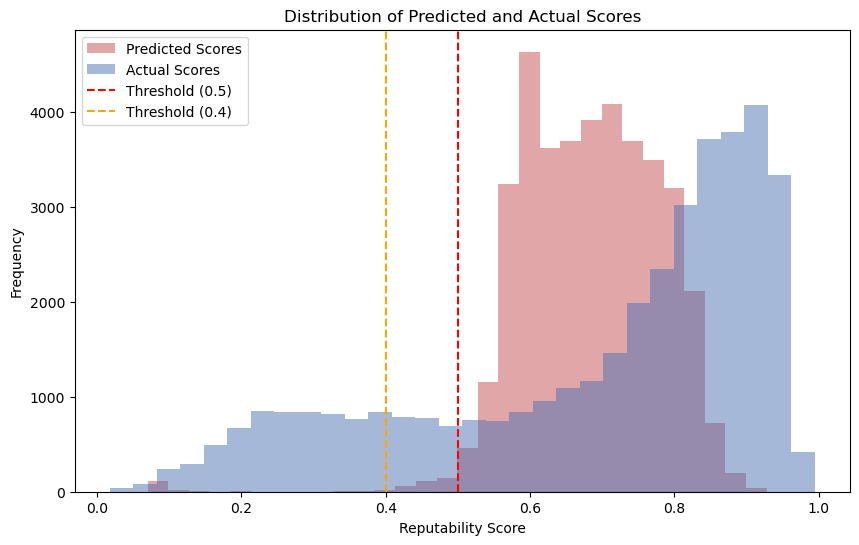

In [127]:
import matplotlib.pyplot as plt

# Plot distribution of predicted and actual scores
plt.figure(figsize=(10, 6))
plt.hist(y_pred.flatten(), bins=30, alpha=0.5, label='Predicted Scores', color='#C44E52')
plt.hist(y_test, bins=30, alpha=0.5, label='Actual Scores', color='#4C72B0')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.axvline(x=0.4, color='orange', linestyle='--', label='Threshold (0.4)')
plt.title('Distribution of Predicted and Actual Scores')
plt.xlabel('Reputability Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()